In [1]:
### import libraries

import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import os
import pycountry_convert as pc
import matplotlib.dates as mdates
import pandas_profiling

In [2]:
### function to create directories

def create_dir(dirName):
    try:
        os.mkdir(dirName)
        print("Directory: " , dirName ,  " created ") 
    except FileExistsError:
        print("Directory: " , dirName ,  " already exists")

In [3]:
### Create directories

directories = ['output','data']

for i in directories:
    create_dir(i)

Directory  output  already exists
Directory  data  already exists


In [4]:
### Import Databases

# Import Our World in Data latest database
mf_original = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
mf = mf_original
mf.to_csv('data/owid-covid-data.csv') #Save file locally

# Import 0xCGRT latest database
df_original = pd.read_csv('https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/OxCGRT_latest.csv')
df = df_original
#Save file locally
df.to_csv('data/OxCGRT_latest.csv') #Save file locally

# Import Google latest database
gf_original = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')
gf = gf_original
#Save file locally
df.to_csv('data/Global_Mobility_Report.csv') #Save file locally

# Change column names to match mf
df = df.rename(columns = {'CountryName' : 'location', 'Date' : 'date', 'ConfirmedCases': 'total_cases', 'ConfirmedDeaths' : 'total_deaths', 'CountryCode' : 'iso_code'})
gf = gf.rename(columns = {'country_region' : 'location', 'country_region_code' : 'iso_code'})

# Match date format
mf['date'] = pd.to_datetime(mf.date,format='%Y-%m-%d') 
df['date'] = pd.to_datetime(df.date,format='%Y%m%d')
gf['date'] = pd.to_datetime(gf.date,format='%Y-%m-%d') 

/Users/leonardveillon/anaconda3/envs/corona/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
### Correction

gf['iso_code'] = np.where((gf.location == 'Namibia'),'NA',gf.iso_code)
#gf[gf.location.isin(['Namibia'])]

#Delete 'International' and 'World' entries
mf.drop(mf[mf.location == 'World'].index, inplace=True)
mf.drop(mf[mf.location == 'International'].index, inplace=True)

# **Databases features**

List of all variables in the databases

In [6]:
### Our World in Data columns

# mf.dtypes

In [7]:
### Our World in Data Profile_report

mf_profile = mf.profile_report(title='Pandas Profiling Report')
mf_profile.to_file('report/Our World in Data_Profiling Report.html')

In [8]:
### 0xCGRT in Data columns

#df.dtypes

In [9]:
### 0xCGRT Profile_report

df_profile = df.profile_report(title='Pandas Profiling Report')
df_profile.to_file('report/0xCGRT_Profiling Report.html')

In [10]:
### Google Mobility columns

gf.dtypes

iso_code                                                      object
location                                                      object
sub_region_1                                                  object
sub_region_2                                                  object
metro_area                                                    object
iso_3166_2_code                                               object
census_fips_code                                             float64
date                                                  datetime64[ns]
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
dtype: object

In [11]:
### Google Mobility Profile_report

gf_profile = gf.profile_report(title='Pandas Profiling Report')
gf_profile.to_file('report/Google_mobility_Profiling Report.html')

In [12]:
### Merge mf and df into a new database named 'merge'

merge = pd.merge(mf, df, how = 'left', on = ['location','date'], suffixes=('_left', '_right'))
merge = merge.sort_values(by=['location', 'date'], ascending=True)

# # Compare values
# merge['comp'] = np.where(merge["total_cases_left"] == merge["total_cases_right"], True, False)
# merge_temp = merge[merge['comp'] == False]
# merge_temp[['date', 'location', 'total_cases_left', 'total_cases_right', 'total_deaths_left', 'total_deaths_right', 'comp']].sample(20)

# Drop same columns
merge = merge.drop(['total_cases_right', 'total_deaths_right', 'iso_code_right', 'stringency_index'], axis=1)

# Rename columns
merge = merge.rename(columns = {'total_cases_left' : 'total_cases', 'total_deaths_left' : 'total_deaths',
                               'iso_code_left' : 'iso_code', 'StringencyIndex' : 'stringency_index'})

# Add death rate
merge['death_rate'] = merge['total_deaths'] / merge['total_cases']

# Save new database
merge.to_csv('data/Merged.csv') #Save file locally
#merge.info()

# **Correlations**

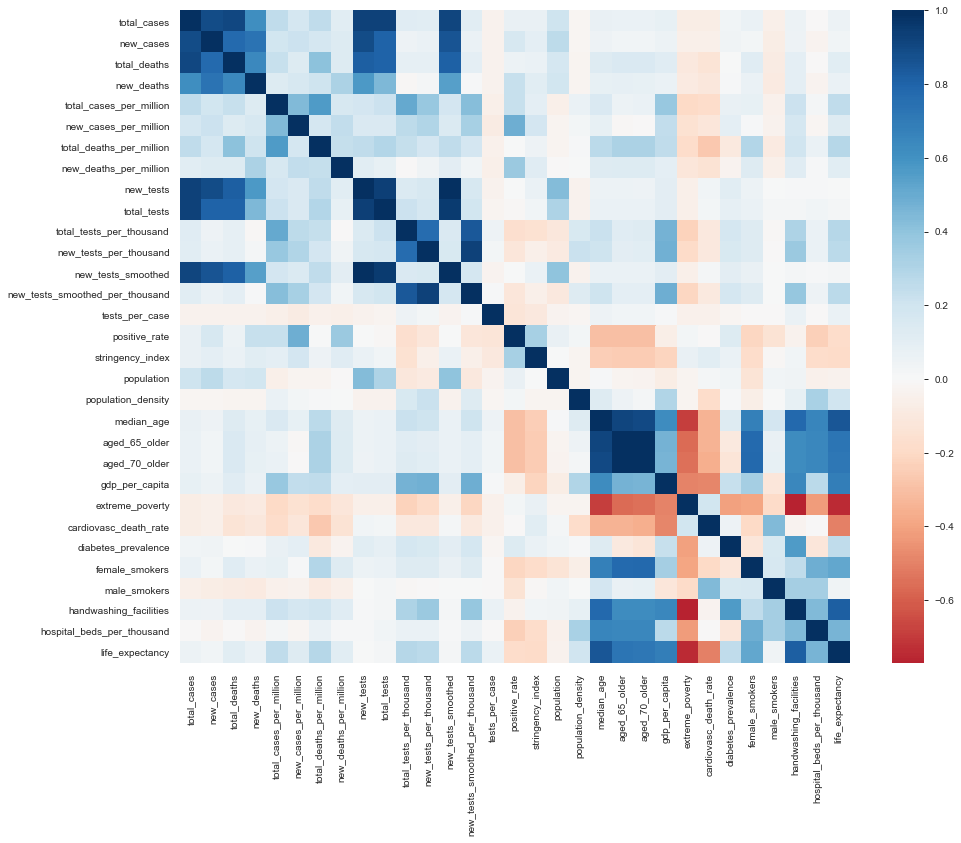

In [13]:
### Correlations

mf_corr = mf.corr()

# Heat map
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(mf_corr, center=0, cmap="RdBu", ax=ax)
plt.savefig('output/Correlations_Our_world_in_data' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
### # Every relationship (slow rendering)

# plot = sns.pairplot(mf, height=2.5);
# plot.savefig("output/Pairplot_mf.png", format="PNG", dpi=300, bbox_inches='tight')

# **Average features per country**

Data is summarized by country. 

In [15]:
### Average features per country

# Import demographic index
demo = pd.read_csv('data/democratic_index.csv')

# Features
temp = merge
death_rate = temp.groupby(['location'])['death_rate'].mean()
gdp = temp.groupby(['location'])['gdp_per_capita'].mean()
pop_density = temp.groupby(['location'])['population_density'].mean()
max_deaths = temp.groupby(['location'])['total_deaths'].max()
max_cases = temp.groupby(['location'])['total_cases'].max()
max_cases_per_m = temp.groupby(['location'])['total_cases_per_million'].max()
max_deaths_per_m = temp.groupby(['location'])['total_deaths_per_million'].max()
pop = temp.groupby(['location'])['population'].max()
beds = temp.groupby(['location'])['hospital_beds_per_thousand'].max()
test = temp.groupby(['location'])['total_tests_per_thousand'].mean()
y65 = temp.groupby(['location'])['aged_65_older'].mean()
mean_stringency = temp.groupby(['location'])['stringency_index'].mean()
democratic_index = demo.groupby(['location'])['demo_score'].mean()

demo_str = pd.merge(democratic_index, mean_stringency, how='left', on = ['location'])

frame = {'death_rate': death_rate, 'gdp': gdp, 'pop_density': pop_density, 'max_cases': max_cases,
         'max_cases_per_m': max_cases_per_m, 'max_deaths': max_deaths, 'max_deaths_per_m': max_deaths_per_m,
         'pop': pop, 'beds': beds, 'test': test, 'y65': y65, 'mean_stringency': mean_stringency, 'democratic_index': democratic_index}   

countries_data = pd.DataFrame(frame)

# Remove countries with less than 1M people, 0 deaths, 0 death rate
countries_data = countries_data[(countries_data['pop'] >= 1000000)]
countries_data = countries_data[(countries_data['death_rate'] > 0)]
countries_data = countries_data[(countries_data['max_deaths'] > 0)]

countries_data.describe()

death_rate            gdp  pop_density     max_cases  max_cases_per_m  \
count  151.000000     147.000000   148.000000  1.510000e+02       151.000000   
mean     0.033792   18456.288633   198.098716  1.311482e+05      3278.766616   
std      0.030748   19167.389126   676.693695  5.154709e+05      5261.337765   
min      0.000363     661.240000     3.078000  2.140000e+02         6.616000   
25%      0.011873    3756.222500    35.811250  2.720000e+03       299.035500   
50%      0.028066   12236.706000    81.006000  1.462600e+04      1042.684000   
75%      0.042215   27012.304500   150.214000  7.028150e+04      4181.610500   
max      0.201325  116935.600000  7915.731000  5.044864e+06     39203.279000   

          max_deaths  max_deaths_per_m           pop       beds        test  \
count     151.000000         151.00000  1.510000e+02  132.00000   83.000000   
mean     4840.052980          95.16255  5.102210e+07    2.93875   30.255906   
std     17344.687657         160.06217  1.660852e+08    2.47952   37.085865   
min         1.000000           0.08400  1.160164e+06    0.10000    0.575511   
25%        62.500000           5.85400  5.440442e+06    1.10000    4.107158   
50%       256.000000          20.71500  1.189078e+07    2.21000   17.322181   
75%      1675.000000         100.63200  3.779438e+07    4.20250   46.784454   
max    162938.000000         851.79700  1.439324e+09   13.05000  208.730937   

              y65  mean_stringency  democratic_index  
count  148.000000       144.000000        144.000000  
mean     8.898926        59.942682          5.453542  
std      6.487178        16.431338          2.451433  
min      1.144000         8.654398          0.000000  
25%      3.164500        48.734011          3.485000  
50%      6.335500        59.561689          5.695000  
75%     14.753250        72.626526          7.445000  
max     27.049000        97.198926          9.870000

In [16]:
### Countries_data Profile_report

countries_data_profile = countries_data.profile_report(title='Pandas Profiling Report')
countries_data_profile.to_file('report/Countries_data_Profiling Report.html')

In [17]:
### 10 worst fatality rates

worst = countries_data.sort_values(by=['death_rate'], ascending=[False]).head(10)
worst

death_rate        gdp  pop_density  max_cases  \
Yemen             0.201325   1479.147       53.508     1804.0   
Sudan             0.129722   4466.507       23.258    11894.0   
France            0.126507  38605.671      122.578   197921.0   
Nicaragua         0.113437   5321.444       51.667     3902.0   
Belgium           0.108553  42658.576      375.564    74059.0   
Italy             0.107827  35220.084      205.859   250566.0   
United Kingdom    0.105736  39753.244      272.898   310825.0   
Hungary           0.104966  26777.561      108.043     4696.0   
Netherlands       0.100142  48472.545      508.544    58564.0   
Philippines       0.097586   7599.188      351.873   129913.0   

                max_cases_per_m  max_deaths  max_deaths_per_m          pop  \
Yemen                    60.484       515.0            17.267   29825968.0   
Sudan                   271.247       773.0            17.629   43849269.0   
France                 3032.179     30324.0           464.568   65273512.0   
Nicaragua               589.021       123.0            18.567    6624554.0   
Belgium                6390.117      9872.0           851.797   11589616.0   
Italy                  4144.202     35205.0           582.268   60461828.0   
United Kingdom         4578.632     46574.0           686.062   67886004.0   
Hungary                 486.111       602.0            62.317    9660350.0   
Netherlands            3417.825      6157.0           359.326   17134873.0   
Philippines            1185.542      2270.0            20.715  109581085.0   

                beds       test     y65  mean_stringency  democratic_index  
Yemen           0.70        NaN   2.922        50.444286              1.95  
Sudan           0.80        NaN   3.548        79.924828              2.70  
France          5.98        NaN  19.718        49.386396              8.12  
Nicaragua       0.90        NaN   5.445        12.134211              1.25  
Belgium         5.64  62.642304  18.571        47.481267              7.64  
Italy           3.18  44.699855  23.021        54.870136              7.52  
United Kingdom  2.54  58.617492  18.517        47.087639              8.52  
Hungary         7.02  15.698702  18.577        61.335203              8.75  
Netherlands     3.32  24.018857  18.779        42.497546              9.01  
Philippines     1.00   4.695087   4.803        64.928726              6.64

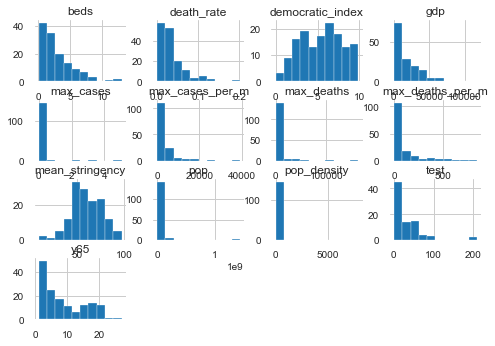

In [18]:
### Histograms

t = countries_data.sort_values(by=['max_cases_per_m'], ascending=[False]).hist()

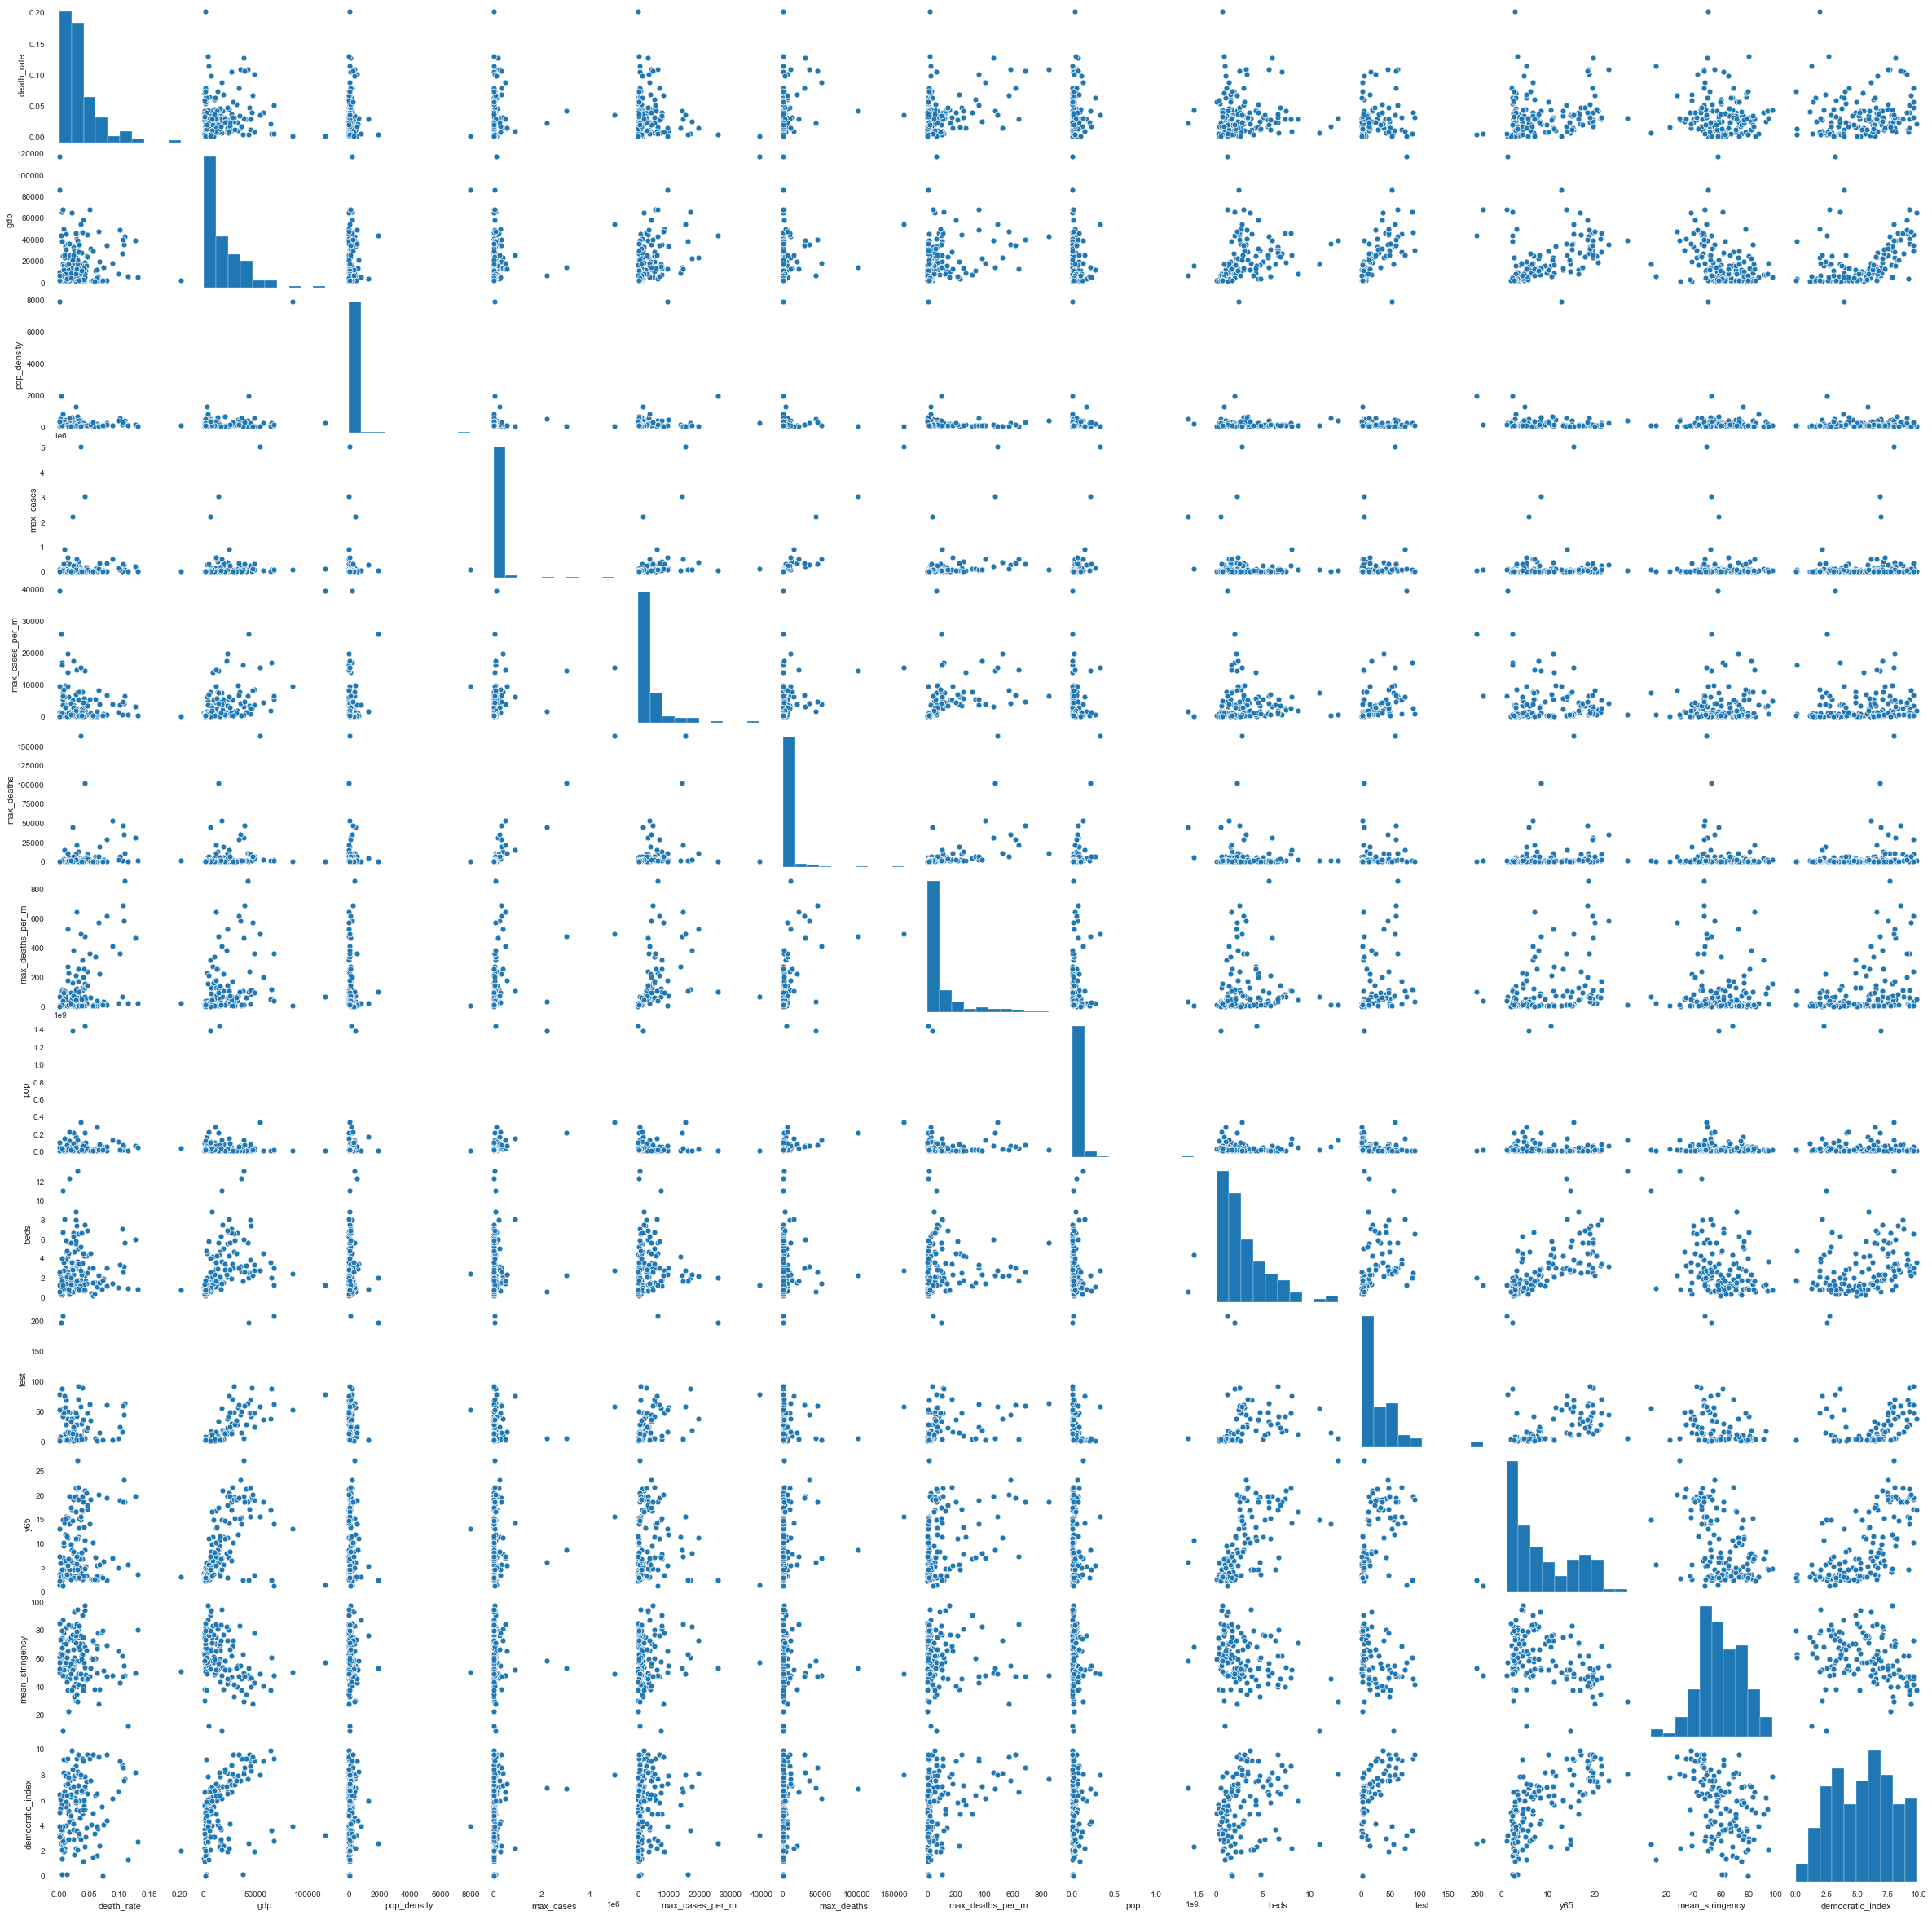

In [19]:
sns.pairplot(countries_data, height=2.5);

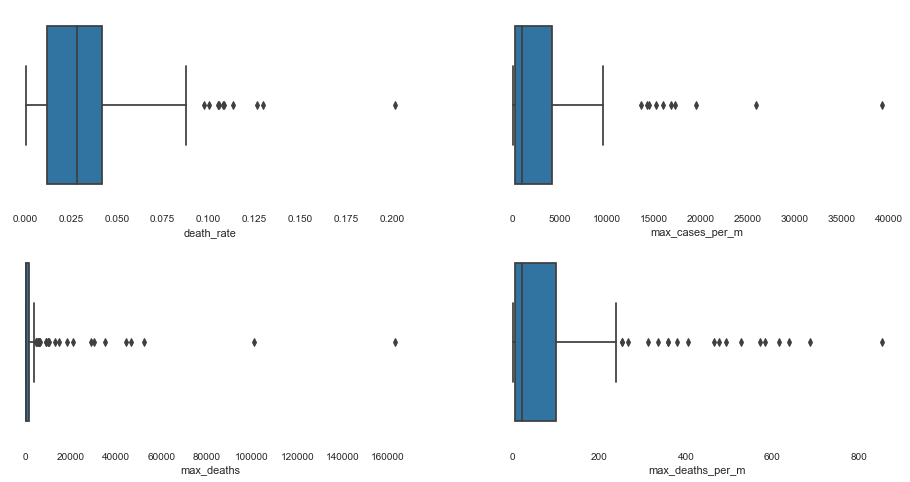

In [20]:
### Plot Countries feature variance

plt.figure(figsize=(16, 8))

# linear
plt.subplot(221)
sns.boxplot(x='death_rate', data=countries_data)

# linear
plt.subplot(222)
sns.boxplot(x='max_cases_per_m', data=countries_data)

# linear
plt.subplot(223)
sns.boxplot(x='max_deaths', data=countries_data)

# linear
plt.subplot(224)
sns.boxplot(x='max_deaths_per_m', data=countries_data)

plt.savefig('output/Countries_data_describe' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

# **Average features per continent**

Let's check the differences between continent


In [21]:
### Average features per continent

temp = merge
death_rate = temp.groupby(['continent'])['death_rate'].mean()
gdp = temp.groupby(['continent'])['gdp_per_capita'].mean()
pop_density = temp.groupby(['continent'])['population_density'].mean()
max_deaths = temp.groupby(['continent'])['total_deaths'].max()
max_cases = temp.groupby(['continent'])['total_cases'].max()
max_cases_per_m = temp.groupby(['continent'])['total_cases_per_million'].max()
max_deaths_per_m = temp.groupby(['continent'])['total_deaths_per_million'].max()
pop = temp.groupby(['continent'])['population'].max()
beds = temp.groupby(['continent'])['hospital_beds_per_thousand'].max()
y65 = temp.groupby(['continent'])['aged_65_older'].mean()

frame = []
frame = {'death_rate': death_rate, 'gdp': gdp, 'pop_density': pop_density, 'max_cases': max_cases, 'max_cases_per_m': max_cases_per_m, 'max_deaths': max_deaths, 'max_deaths_per_m': max_deaths_per_m, 'pop': pop, 'beds': beds, 'y65': y65} 
continents_data = pd.DataFrame(frame)

continents_data.describe()

death_rate           gdp  pop_density     max_cases  max_cases_per_m  \
count    6.000000      6.000000     6.000000  6.000000e+00         6.000000   
mean     0.031354  21067.499439   265.022986  1.960640e+06     18170.986167   
std      0.010777  10161.426302   253.793541  1.876590e+06     12460.117820   
min      0.017279   5679.044337    25.866824  2.108400e+04      2476.553000   
25%      0.022864  15963.420274    75.424671  6.417775e+05     11395.904500   
50%      0.032806  22990.990505   178.554184  1.551305e+06     18389.797000   
75%      0.040186  25292.512159   432.498289  2.830335e+06     20723.862250   
max      0.043038  35063.388380   648.968233  5.044864e+06     39203.279000   

          max_deaths  max_deaths_per_m           pop       beds        y65  
count       6.000000          6.000000  6.000000e+00   6.000000   6.000000  
mean    60941.666667        474.345500  3.934100e+08   7.965000   9.489282  
std     61194.836039        432.556018  5.219597e+08   4.316729   4.762546  
min       295.000000         34.748000  2.549988e+07   3.840000   3.728991  
25%     18902.500000        198.351250  1.609857e+08   5.200000   7.087035  
50%     45480.000000        379.597000  2.093495e+08   6.050000   9.170198  
75%     87430.250000        602.382250  3.013918e+08  11.362500  10.259688  
max    162938.000000       1237.551000  1.439324e+09  13.800000  17.850804

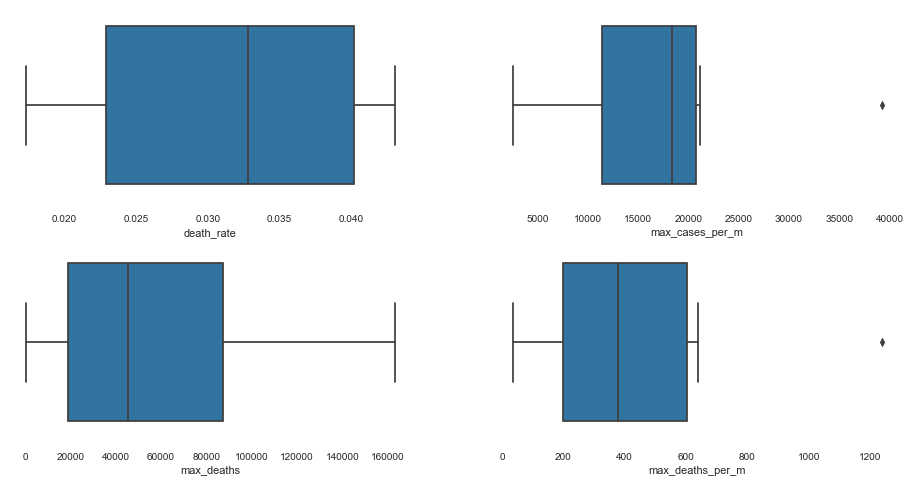

In [22]:
### plot Continents feature variance

plt.figure(figsize=(16, 8))

# linear
plt.subplot(221)
sns.boxplot(x='death_rate', data=continents_data)

# linear
plt.subplot(222)
sns.boxplot(x='max_cases_per_m', data=continents_data)

# linear
plt.subplot(223)
sns.boxplot(x='max_deaths', data=continents_data)

# linear
plt.subplot(224)
sns.boxplot(x='max_deaths_per_m', data=continents_data)

plt.savefig('output/Continents_data_describe' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

# **Overall situation**


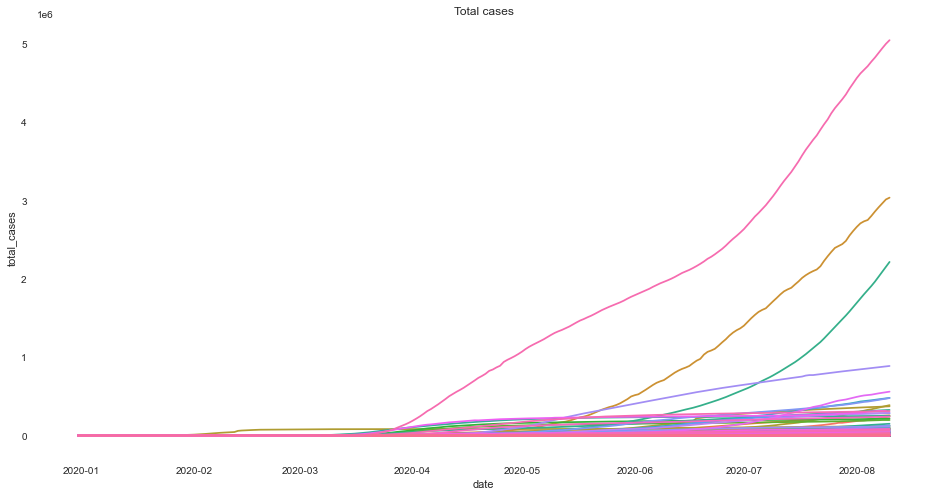

In [23]:
### Total cases with or without lockdown

f, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(data=merge, x="date", y="total_cases", hue='location', estimator='mean', legend=None)

#ax.set(xlim=(10, 1000000))
#ax.set(ylim=(10, 100000))
#ax.set(xscale='log')
#ax.set(yscale='log')

plt.title('Total cases') 
plt.savefig('output/Total_cases_vs_Stay_at_home_' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

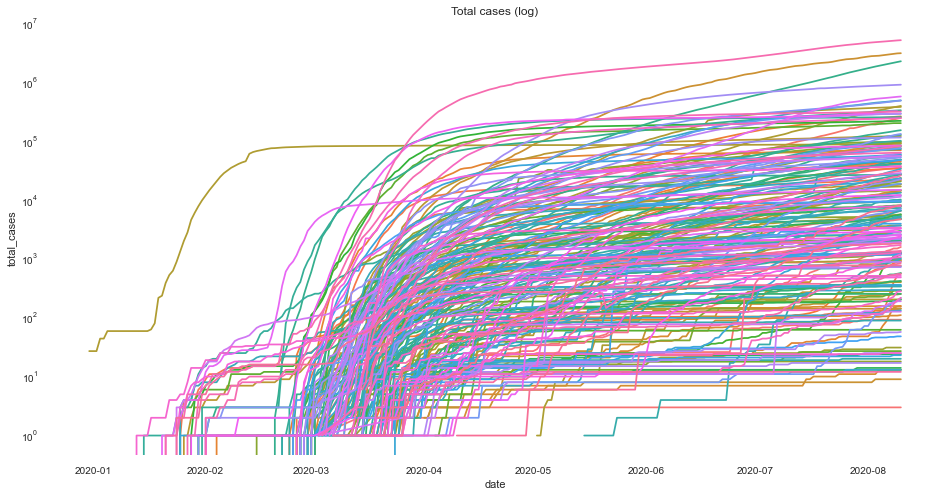

In [24]:
### Total cases (log)

f, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(data=mf, x="date", y="total_cases", hue='location', estimator='mean', legend=None)

#ax.set(xlim=(10, 1000000))
#ax.set(ylim=(None, None))
#ax.set(xscale='log')

ax.set(yscale='log')
plt.title('Total cases (log)') 
plt.savefig('output/Total_cases_log' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

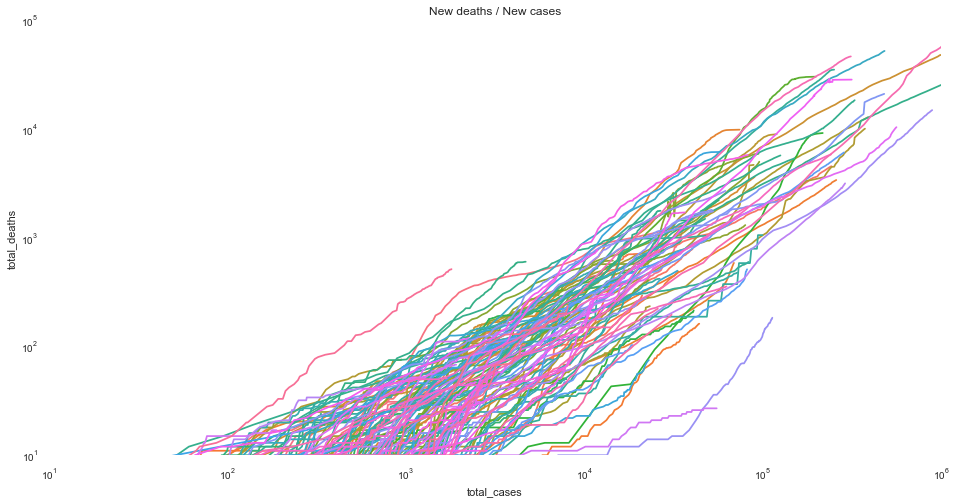

In [25]:
### New cases vs new deaths

f, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(data=merge, x="total_cases", y="total_deaths", hue='location', estimator='mean', legend=None)

ax.set(xlim=(10, 1000000))
ax.set(ylim=(10, 100000))
ax.set(xscale='log')
ax.set(yscale='log')
plt.title('New deaths / New cases')
plt.savefig('output/New_cases_vs_new_deaths' + '.png', format="PNG", dpi=300, bbox_inches='tight')
#plt.show()

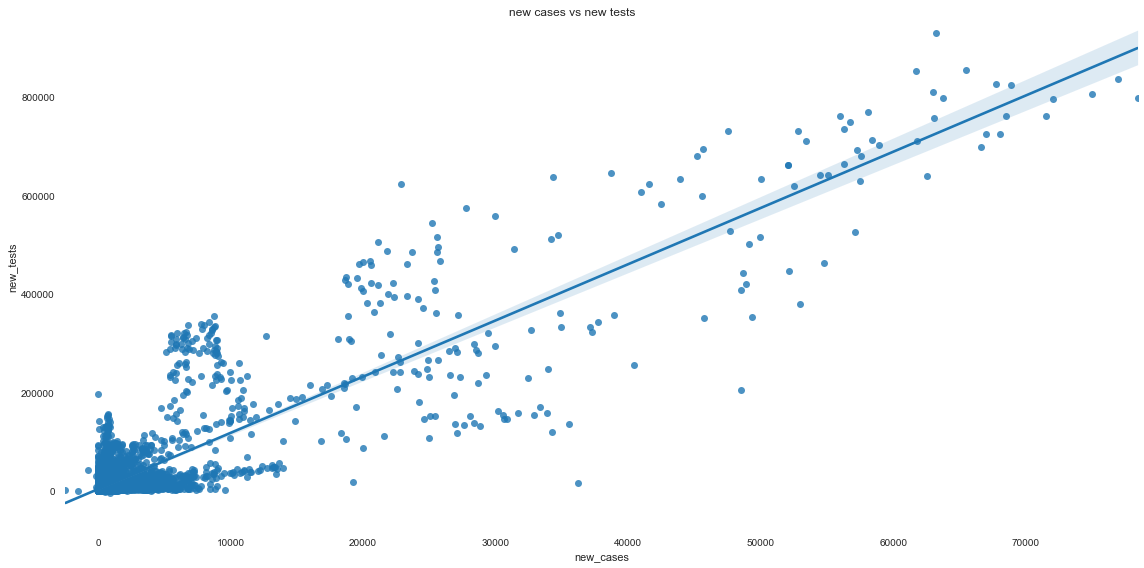

In [26]:
### New cases vs new tests

g = sns.lmplot(data=mf, x="new_cases", y='new_tests', height=8, aspect=2,
                  legend_out=False)
g.fig.suptitle("new cases vs new tests")
plt.savefig('output/New_cases_vs_new_tests.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

## **Selection of countries to compare between**


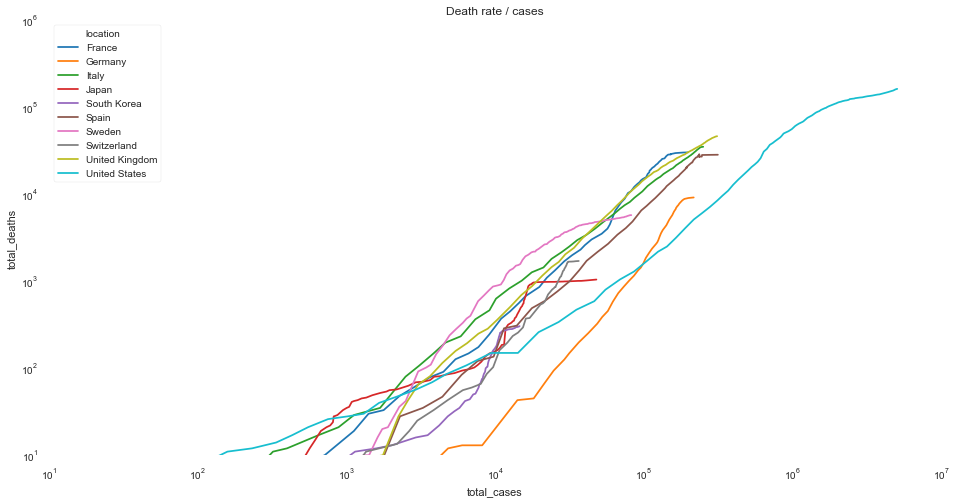

In [27]:
### Country Total cases vs total deaths

countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy',
              'United Kingdom', 'Germany', 'South Korea', 'Japan']

temp = merge[merge.location.isin(countries1)]

f, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(data=temp, x="total_cases", y="total_deaths", hue='location')
ax.set(xlim=(10, 10000000))
ax.set(ylim=(10, 1000000))
ax.set(xscale='log')
ax.set(yscale='log')
plt.title('Death rate / cases')
plt.savefig('output/Death_rate_vs_cases_countries' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

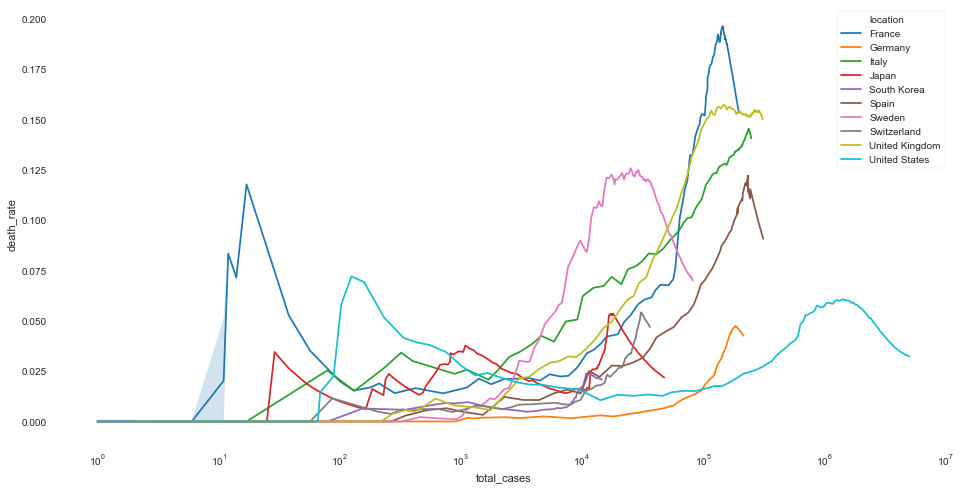

In [28]:
### Total cases vs death rate

countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy',
              'United Kingdom', 'Germany', 'South Korea', 'Japan']

temp = []
temp = merge[merge.location.isin(countries1)]

f, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(data=temp, x="total_cases", y="death_rate", hue='location', estimator='mean')

#axis
ax.set(xscale='log')

plt.savefig('output/Total_cases_vs_death_rate' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

# Stringency Indexes

## Individual situation

Type of measures indicated.

United States


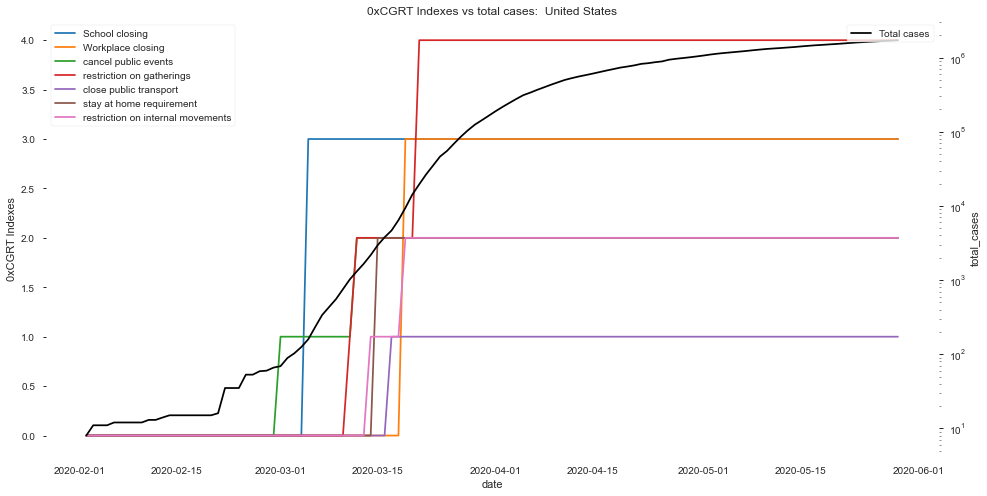

France


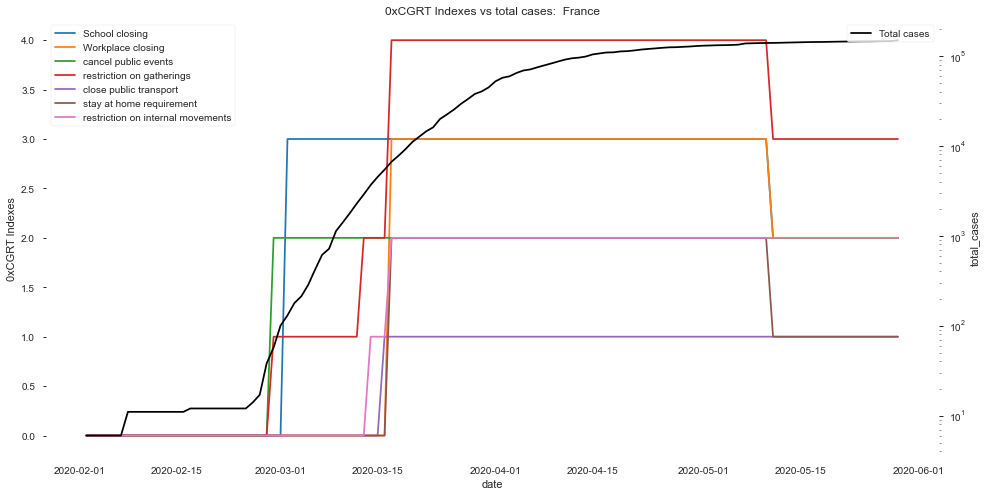

Spain


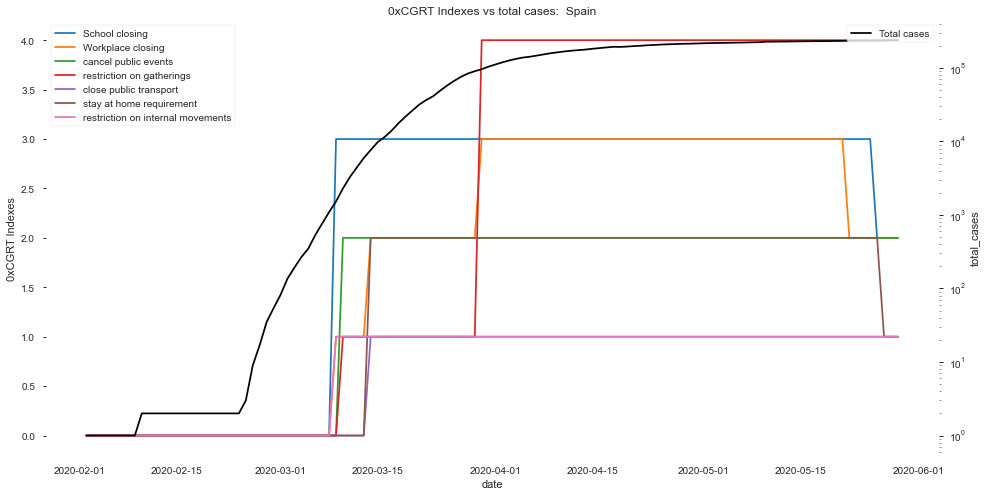

Switzerland


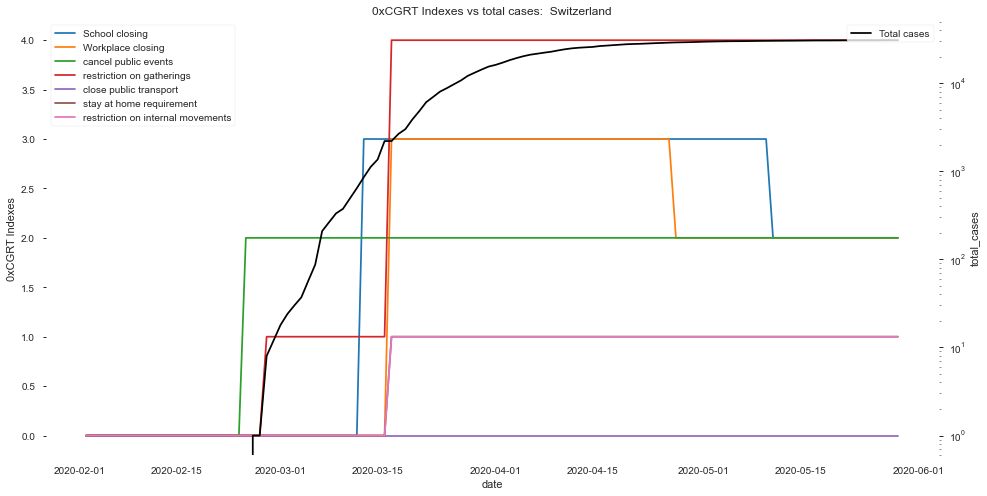

Sweden


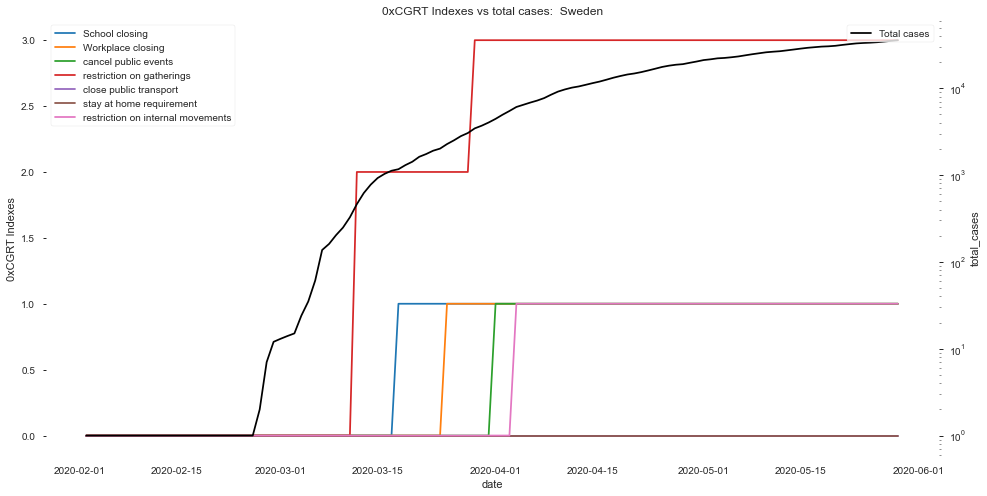

Italy


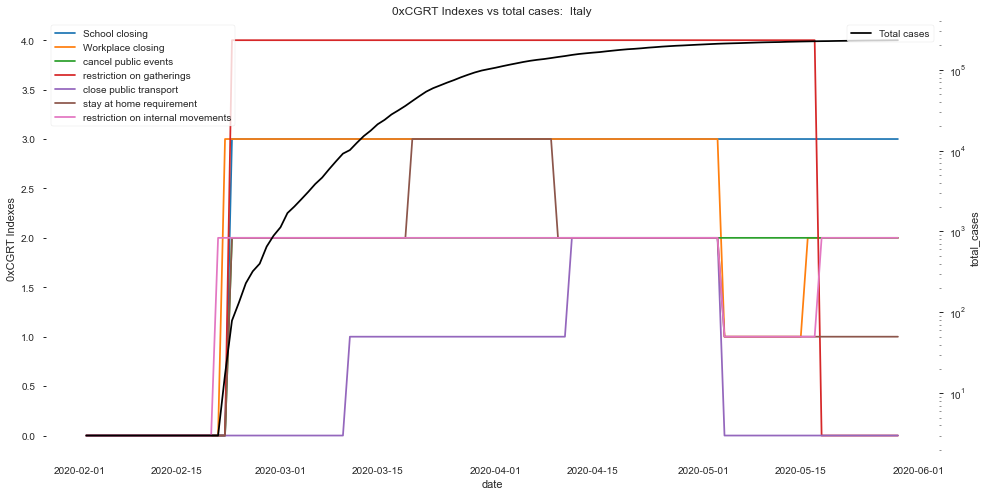

United Kingdom


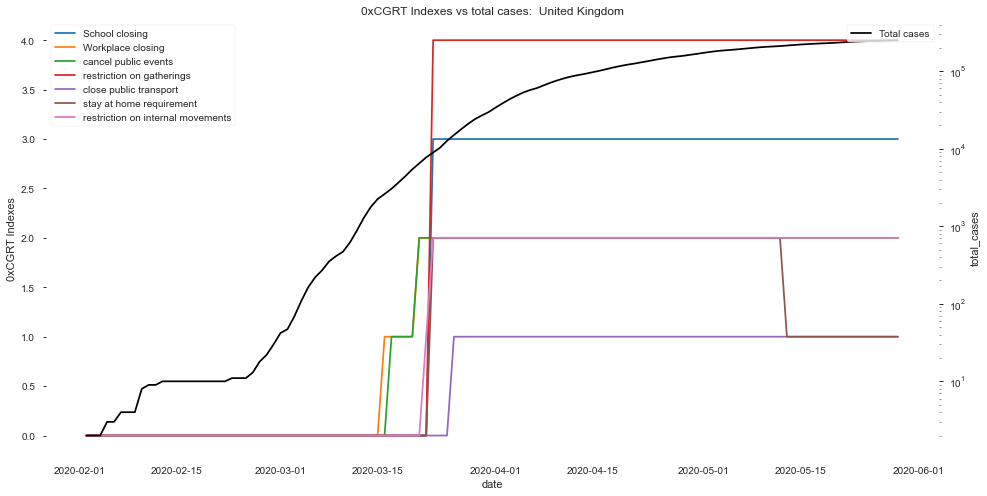

Germany


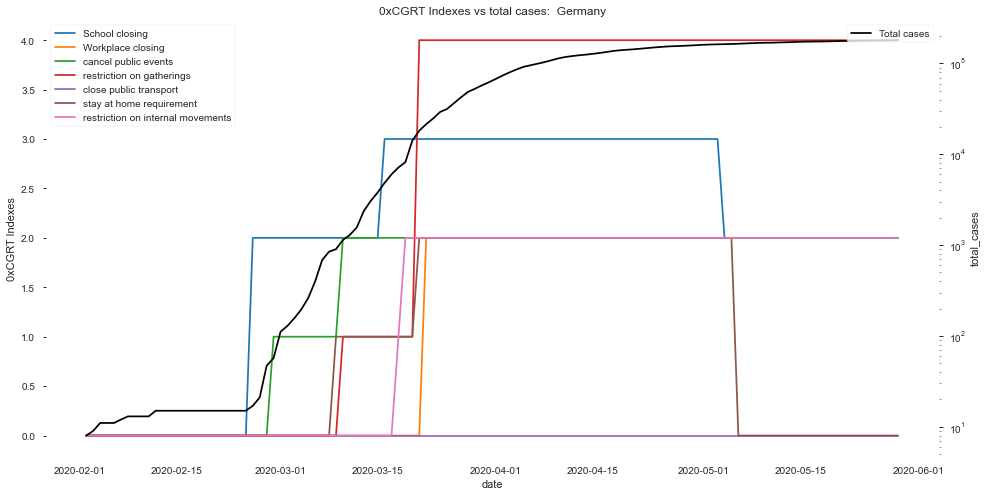

South Korea


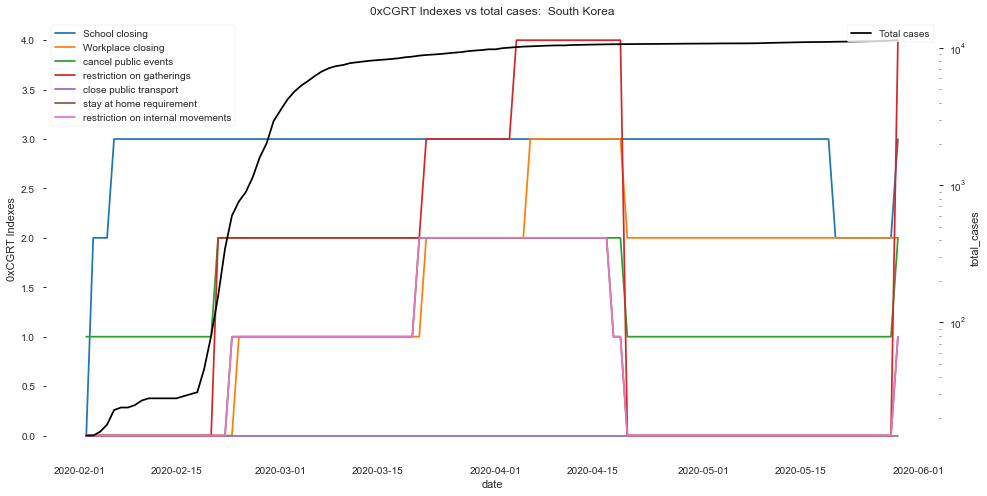

In [29]:
### Comparison 0xCGRT indexes vs cases

# Coutries selected
countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy',
              'United Kingdom', 'Germany', 'South Korea']

# Range
dstart = '2020-02-01'
dend = '2020-05-30'

for country in countries1:
    print(country)
    temp2 = []
    temp2 = merge[merge.location.isin([country])]
    temp2 = temp2[(temp2['date'] > dstart ) & (temp2['date'] < dend )]

    # Plot 1
    f, ax = plt.subplots(figsize=(16, 8))
    ax = sns.lineplot(data=temp2, x="date", y="C1_School closing", label='School closing')
    ax = sns.lineplot(data=temp2, x="date", y="C2_Workplace closing", label='Workplace closing')
    ax = sns.lineplot(data=temp2, x="date", y="C3_Cancel public events", label='cancel public events')
    ax = sns.lineplot(data=temp2, x="date", y="C4_Restrictions on gatherings", label='restriction on gatherings')
    ax = sns.lineplot(data=temp2, x="date", y="C5_Close public transport", label='close public transport')
    ax = sns.lineplot(data=temp2, x="date", y="C6_Stay at home requirements", label='stay at home requirement')
    ax = sns.lineplot(data=temp2, x="date", y="C7_Restrictions on internal movement", label='restriction on internal movements')
    plt.ylabel('0xCGRT Indexes')
    plt.legend(loc=2)

    # Plot 2
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data=temp2, x="date", y="total_cases", label='Total cases', color='black')
    ax2.set(yscale='log')
    plt.legend(loc=1)

    #ax.set(xlim=(10, 1000000))
    plt.title('0xCGRT Indexes vs total cases:  ' + country)
    plt.savefig('output/Stringency_vs_cases_' + country + '.png', format="PNG", dpi=300, bbox_inches='tight')
    plt.show()

United States


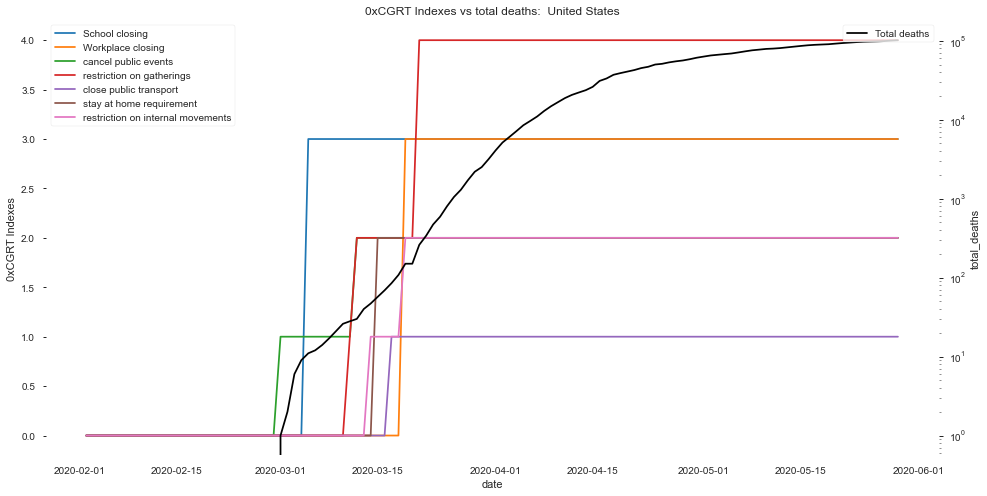

France


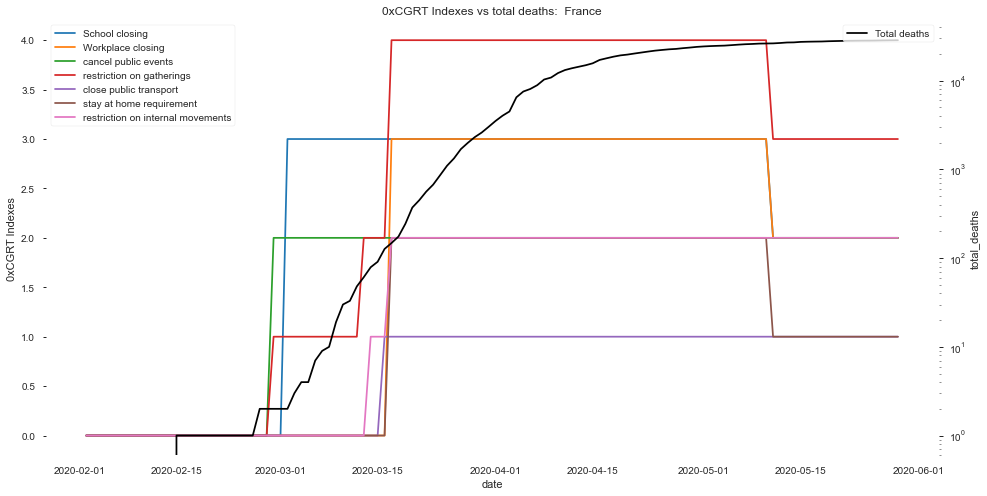

Spain


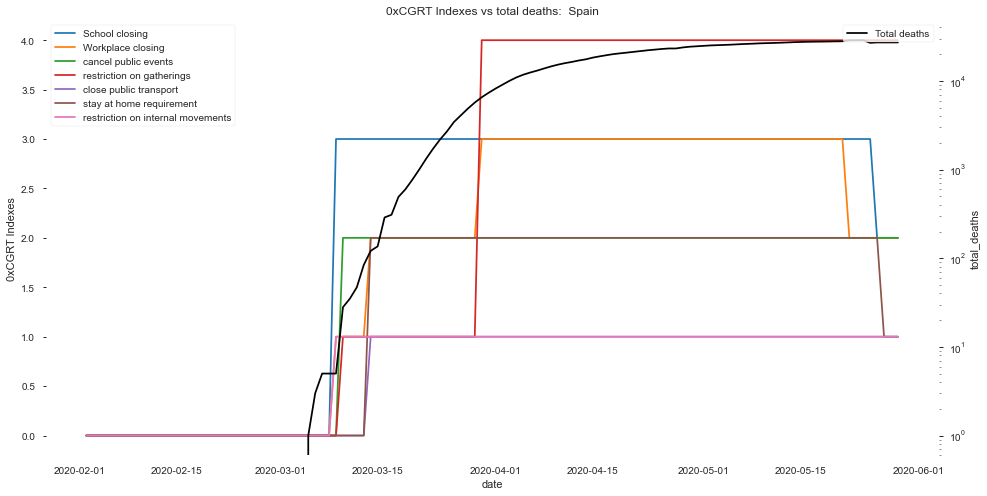

Switzerland


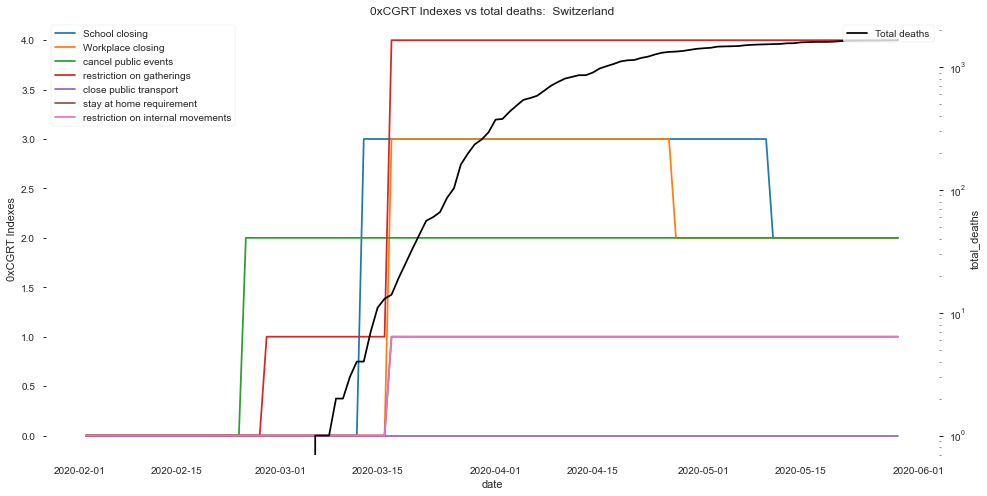

Sweden


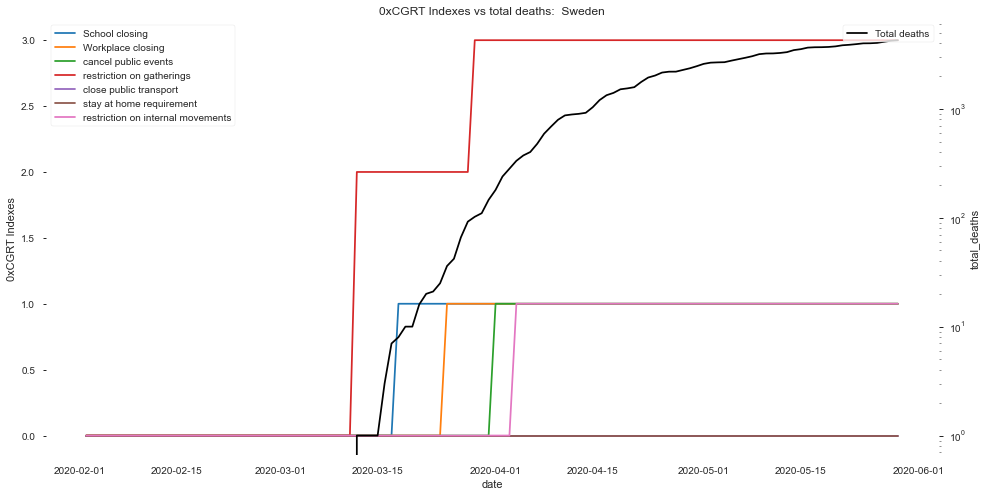

Italy


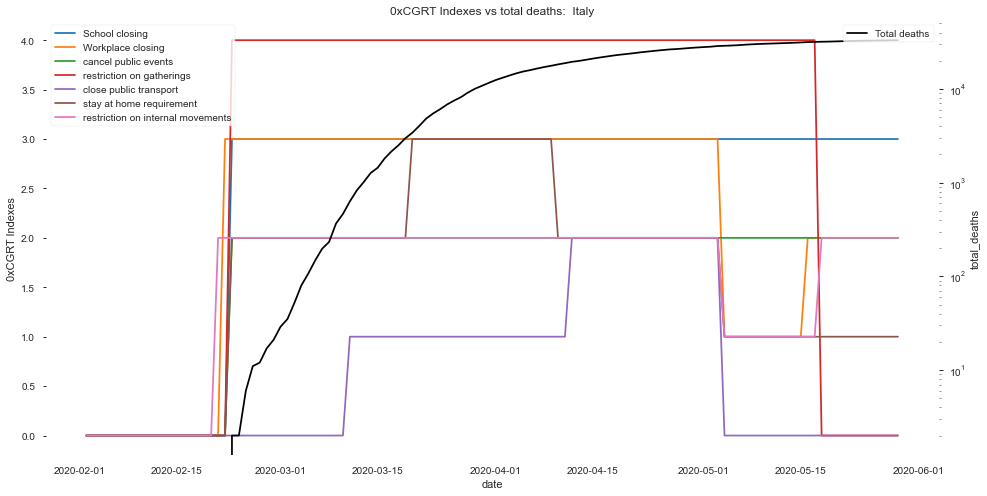

United Kingdom


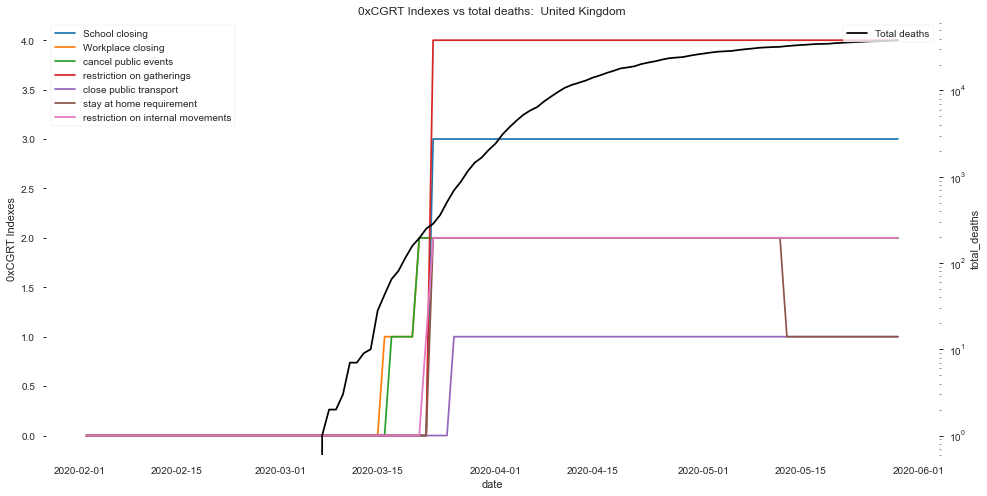

Germany


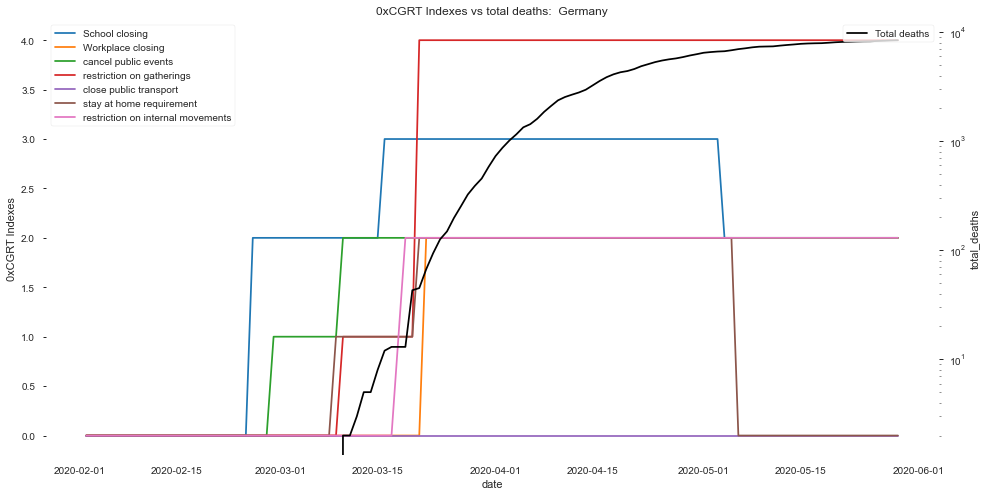

South Korea


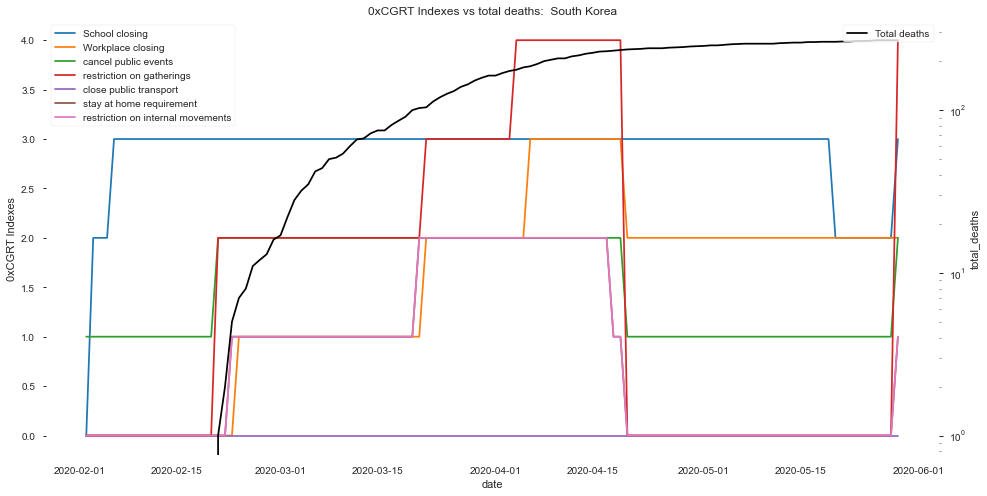

In [30]:
### Comparison 0xCGRT indexes vs cases

# Coutries selected
countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy',
              'United Kingdom', 'Germany', 'South Korea']

# Range
dstart = '2020-02-01'
dend = '2020-05-30'

for country in countries1:
    print(country)
    temp2 = []
    temp2 = merge[merge.location.isin([country])]
    temp2 = temp2[(temp2['date'] > dstart ) & (temp2['date'] < dend )]

    # Plot 1
    f, ax = plt.subplots(figsize=(16, 8))
    ax = sns.lineplot(data=temp2, x="date", y="C1_School closing", label='School closing')
    ax = sns.lineplot(data=temp2, x="date", y="C2_Workplace closing", label='Workplace closing')
    ax = sns.lineplot(data=temp2, x="date", y="C3_Cancel public events", label='cancel public events')
    ax = sns.lineplot(data=temp2, x="date", y="C4_Restrictions on gatherings", label='restriction on gatherings')
    ax = sns.lineplot(data=temp2, x="date", y="C5_Close public transport", label='close public transport')
    ax = sns.lineplot(data=temp2, x="date", y="C6_Stay at home requirements", label='stay at home requirement')
    ax = sns.lineplot(data=temp2, x="date", y="C7_Restrictions on internal movement", label='restriction on internal movements')
    plt.ylabel('0xCGRT Indexes')
    plt.legend(loc=2)

    # Plot 2
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data=temp2, x="date", y="total_deaths", label='Total deaths', color='black')
    ax2.set(yscale='log')
    plt.legend(loc=1)

    #ax.set(xlim=(10, 1000000))
    plt.title('0xCGRT Indexes vs total deaths:  ' + country)
    plt.savefig('output/Stringency_vs_deaths_' + country + '.png', format="PNG", dpi=300, bbox_inches='tight')
    plt.show()

## Health measures

United States


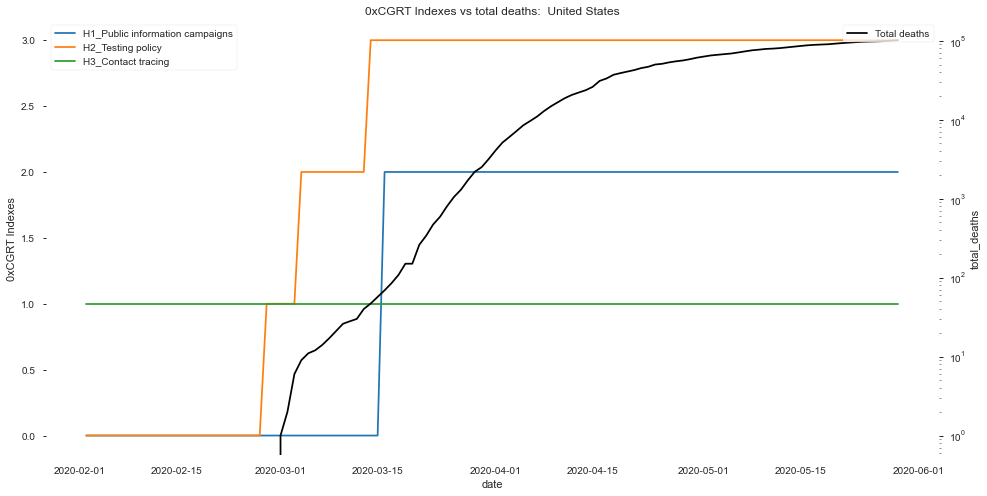

France


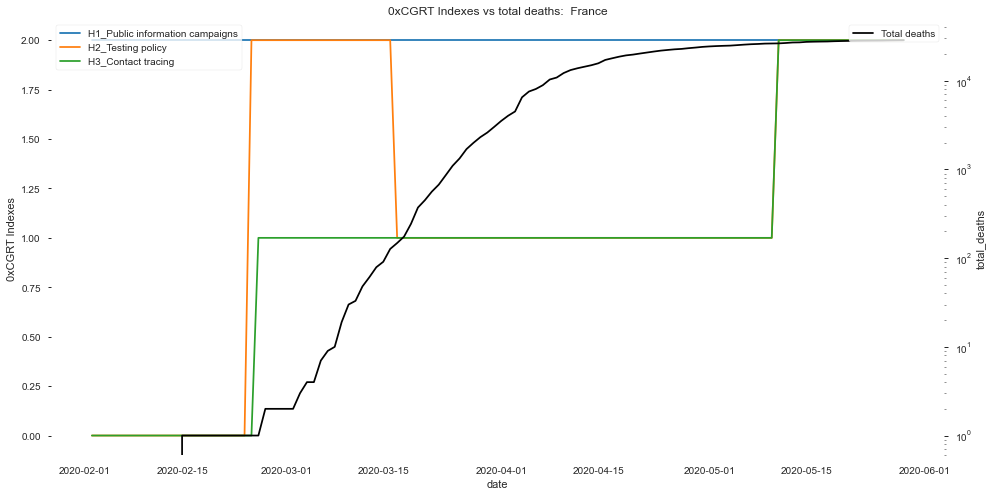

Spain


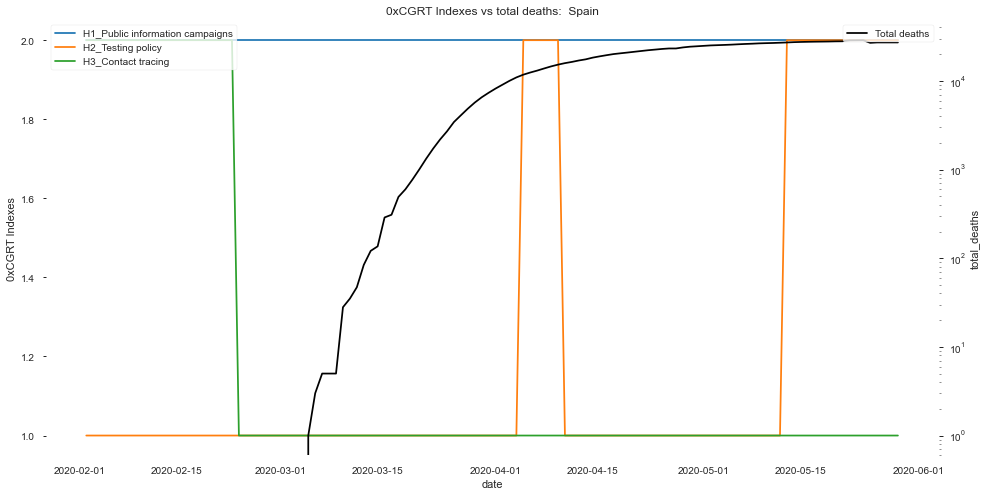

Switzerland


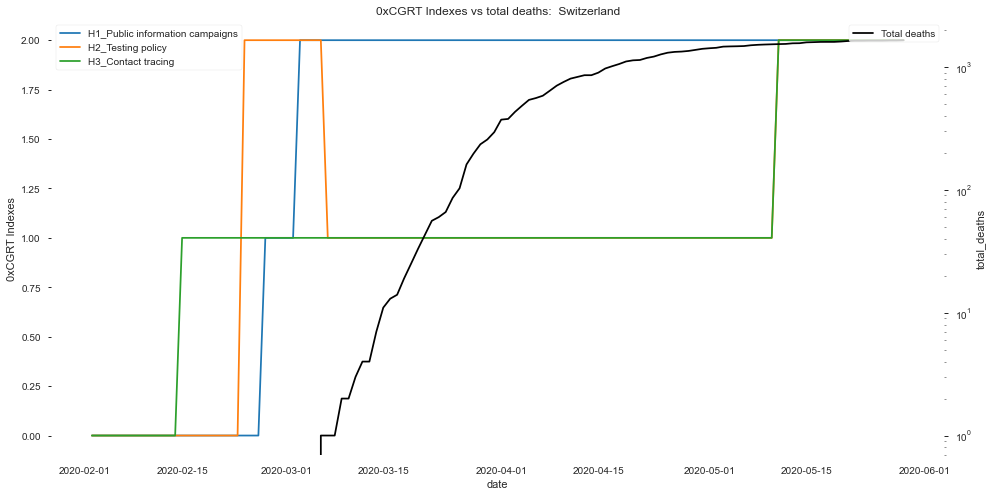

Sweden


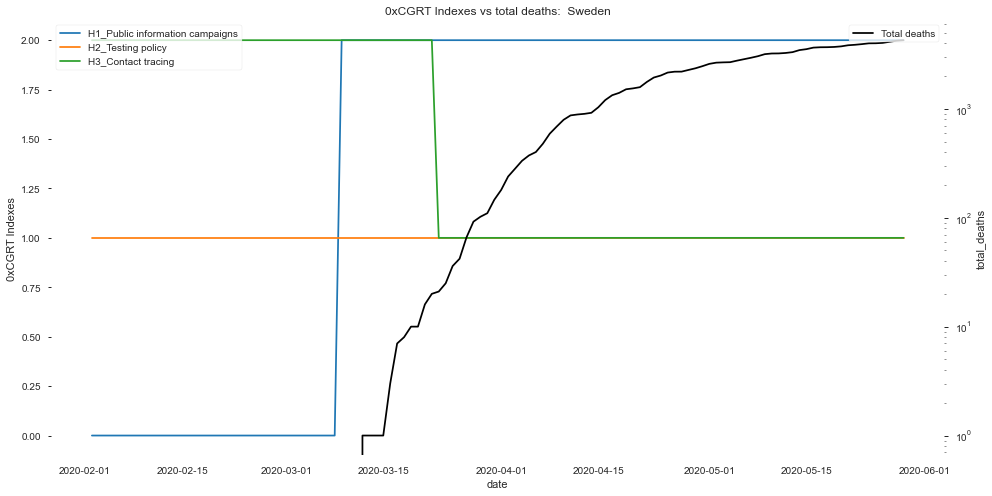

Italy


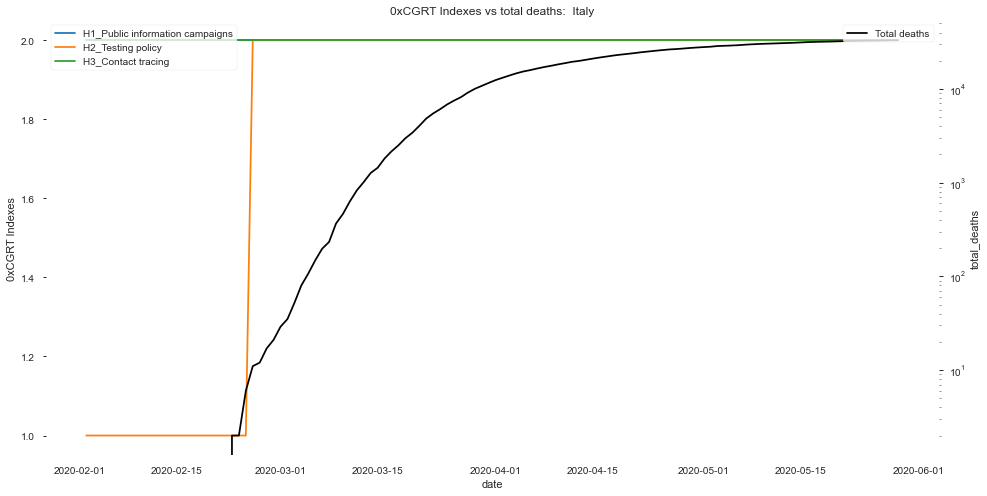

United Kingdom


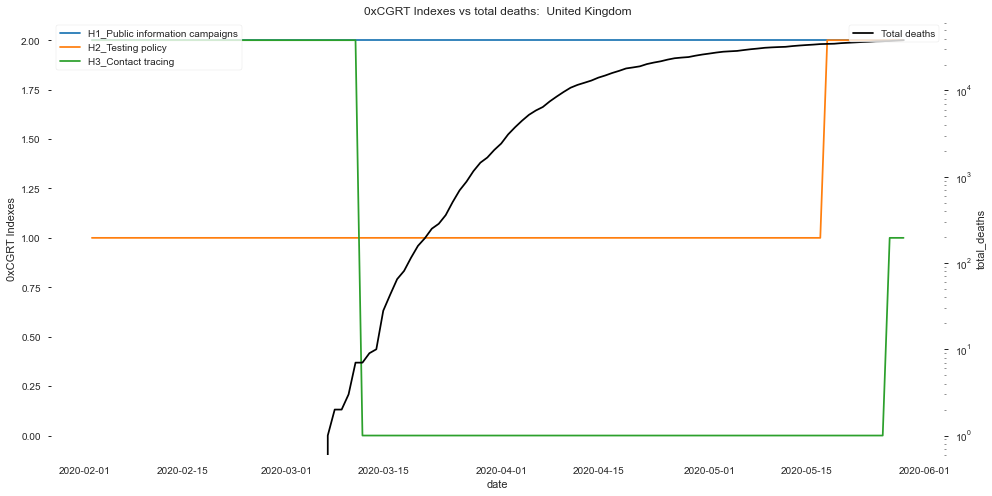

Germany


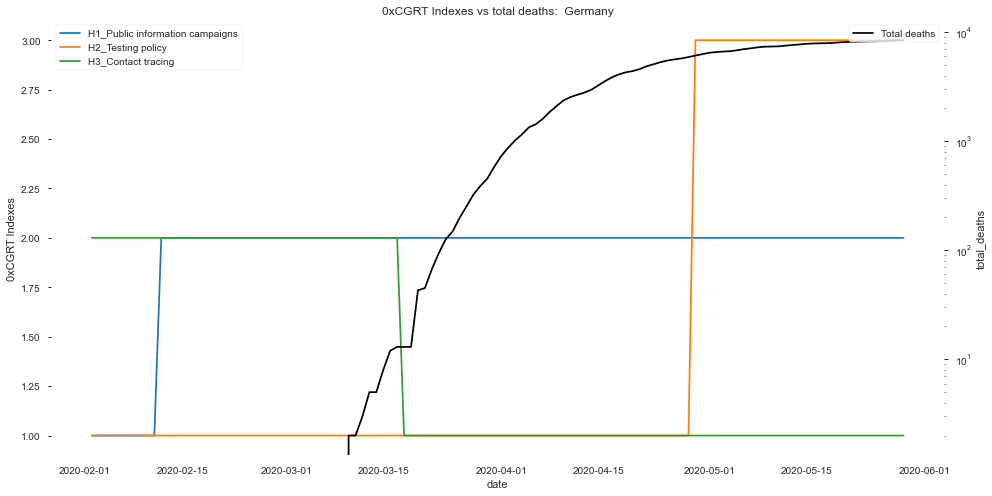

South Korea


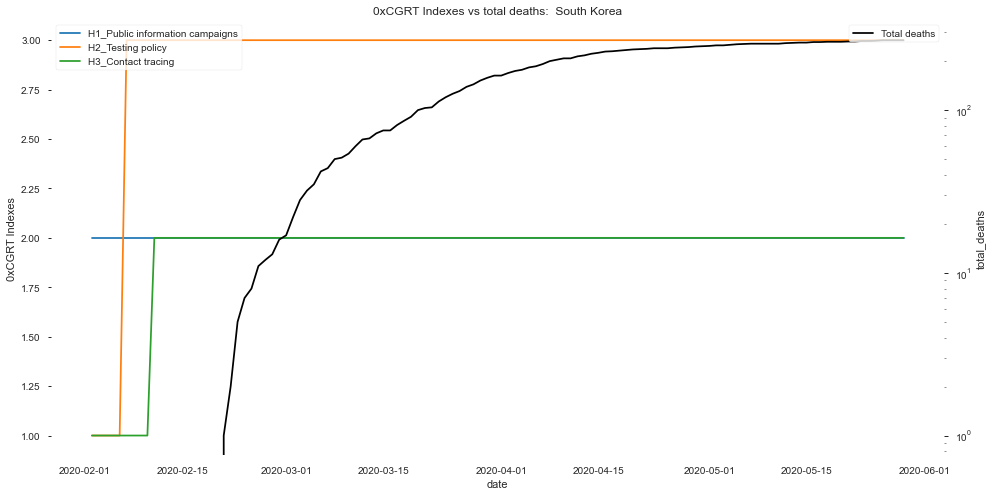

In [31]:
### Health 0xCGRT indexes vs cases

# Coutries selected
countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy',
              'United Kingdom', 'Germany', 'South Korea']

# Range
dstart = '2020-02-01'
dend = '2020-05-30'

for country in countries1:
    print(country)
    temp2 = []
    temp2 = merge[merge.location.isin([country])]
    temp2 = temp2[(temp2['date'] > dstart ) & (temp2['date'] < dend )]

    # Plot 1
    f, ax = plt.subplots(figsize=(16, 8))
    ax = sns.lineplot(data=temp2, x="date", y="H1_Public information campaigns", label='H1_Public information campaigns')
    ax = sns.lineplot(data=temp2, x="date", y="H2_Testing policy", label='H2_Testing policy')
    ax = sns.lineplot(data=temp2, x="date", y="H3_Contact tracing", label='H3_Contact tracing')
    plt.ylabel('0xCGRT Indexes')
    plt.legend(loc=2)

    # Plot 2
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data=temp2, x="date", y="total_deaths", label='Total deaths', color='black')
    ax2.set(yscale='log')
    plt.legend(loc=1)

    #ax.set(xlim=(10, 1000000))
    plt.title('0xCGRT Indexes vs total deaths:  ' + country)
    plt.savefig('output/Stringency_health_vs_deaths_' + country + '.png', format="PNG", dpi=300, bbox_inches='tight')
    plt.show()

# **Number of new cases compared to type of lockdown**

### C6: Stay at home requirements

Record orders to "shelter-in-place" and otherwise confine to the home

0 - no measures\
1: recommend not leaving house\
2 - require not leaving house with exceptions for daily exercise, grocery shopping, and 'essential' trips\
3 - require not leaving house with minimal exceptions (eg allowed to leave once a week, or only one person can leave at a time, etc)




United States


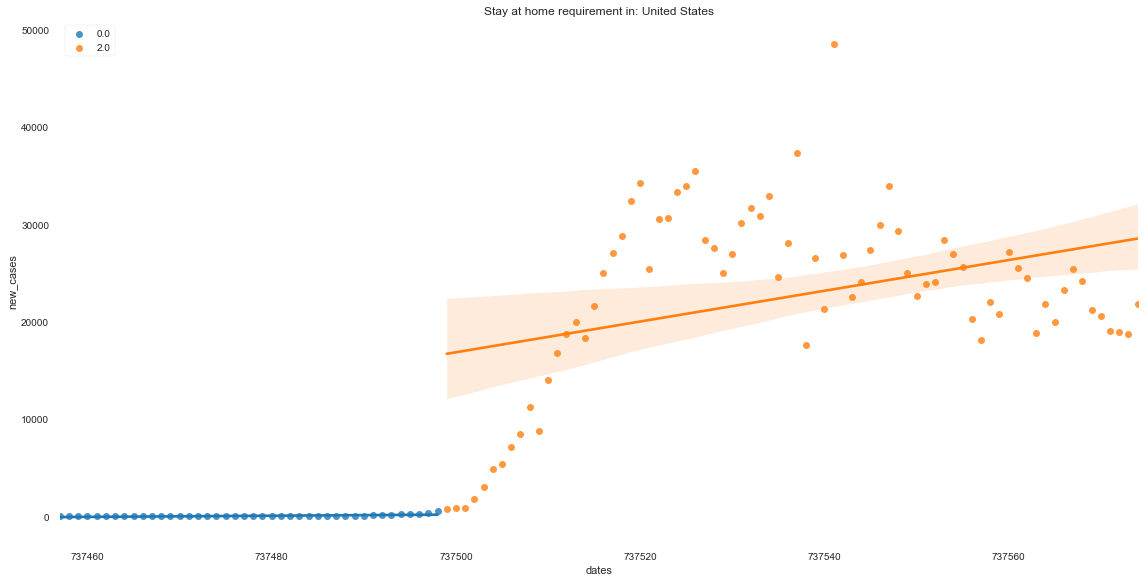

France


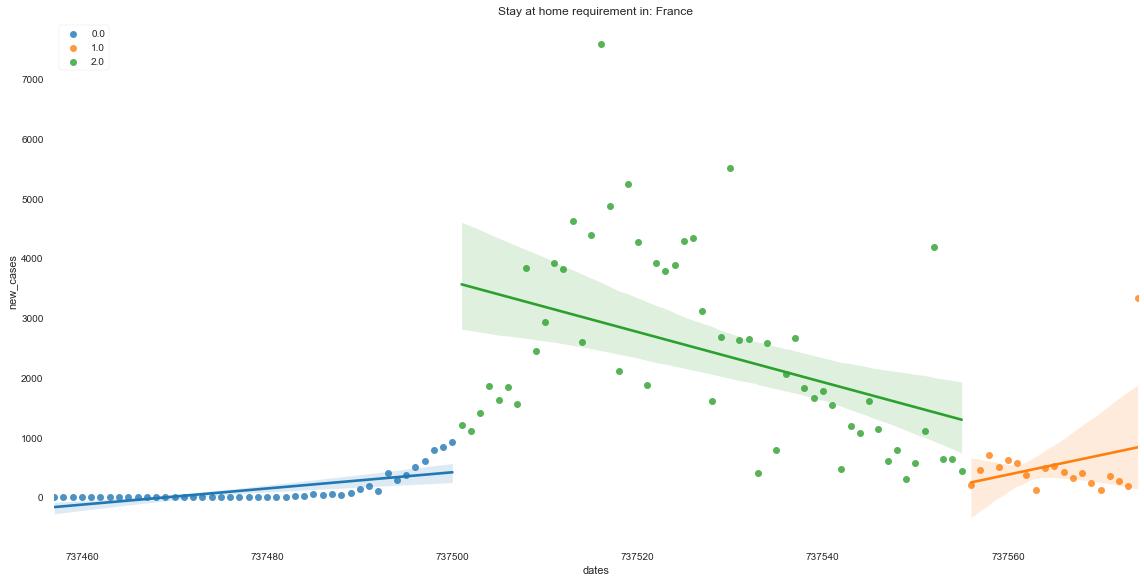

Spain


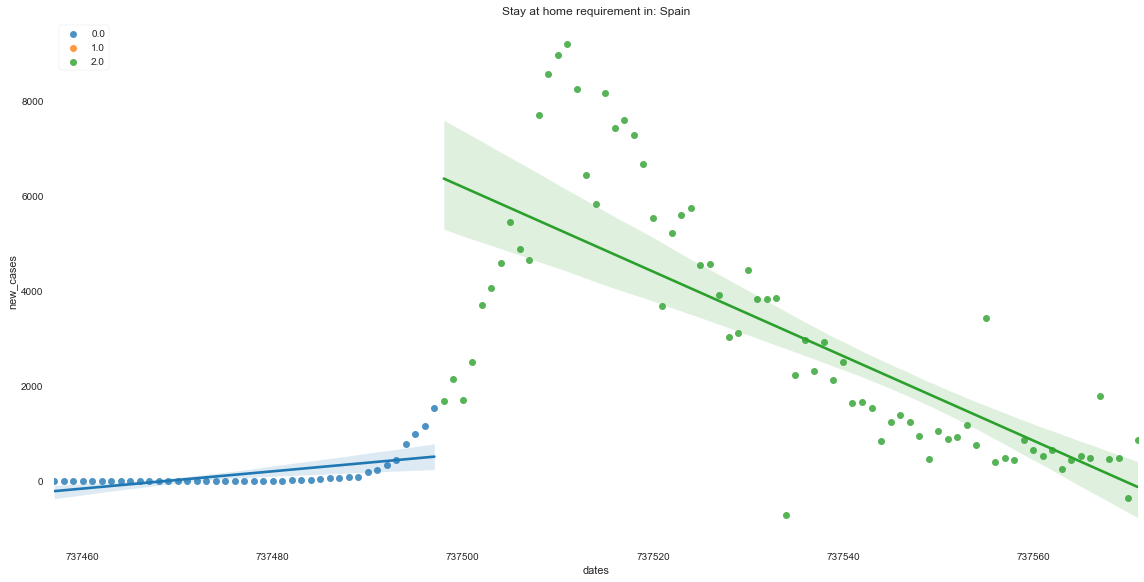

Switzerland


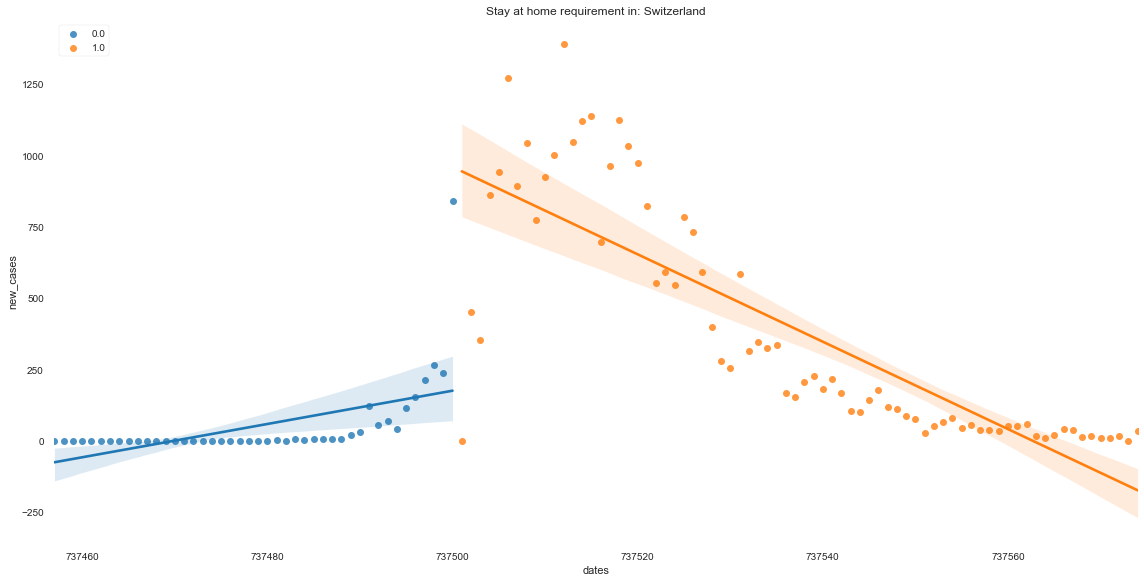

Sweden


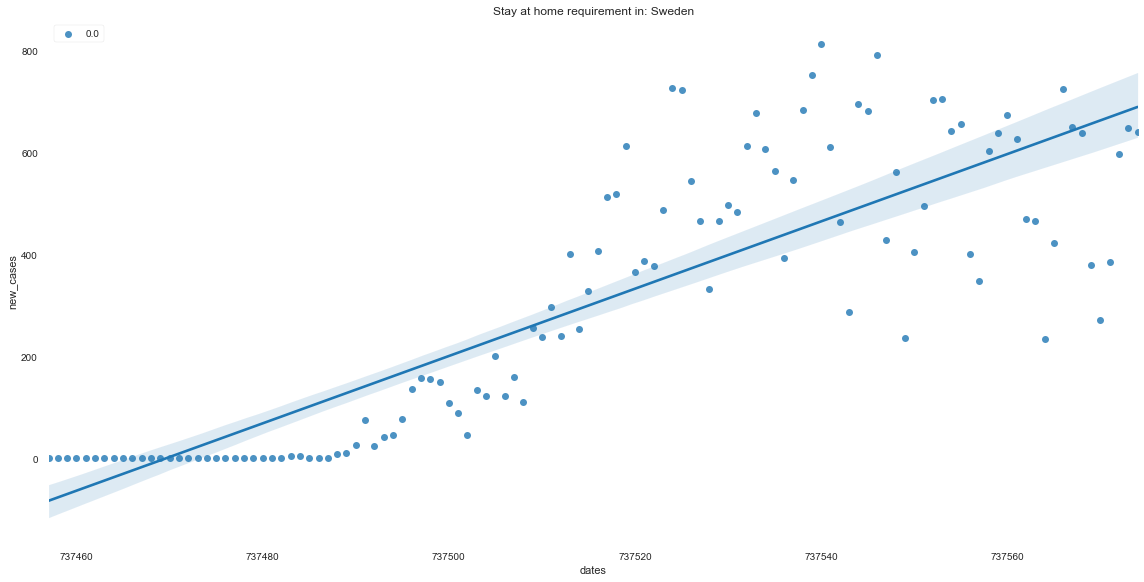

Italy


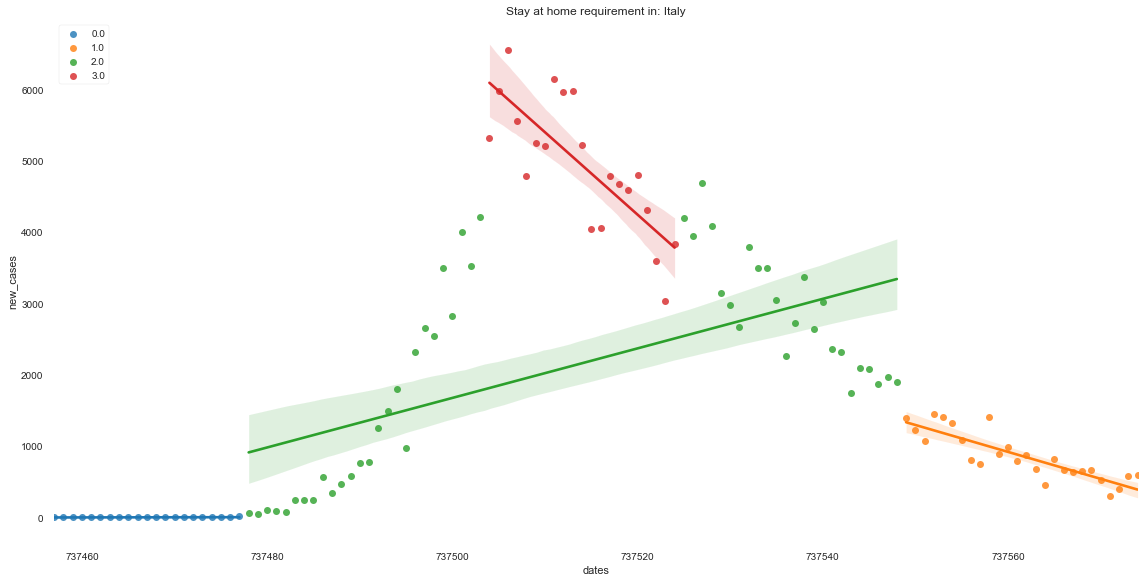

United Kingdom


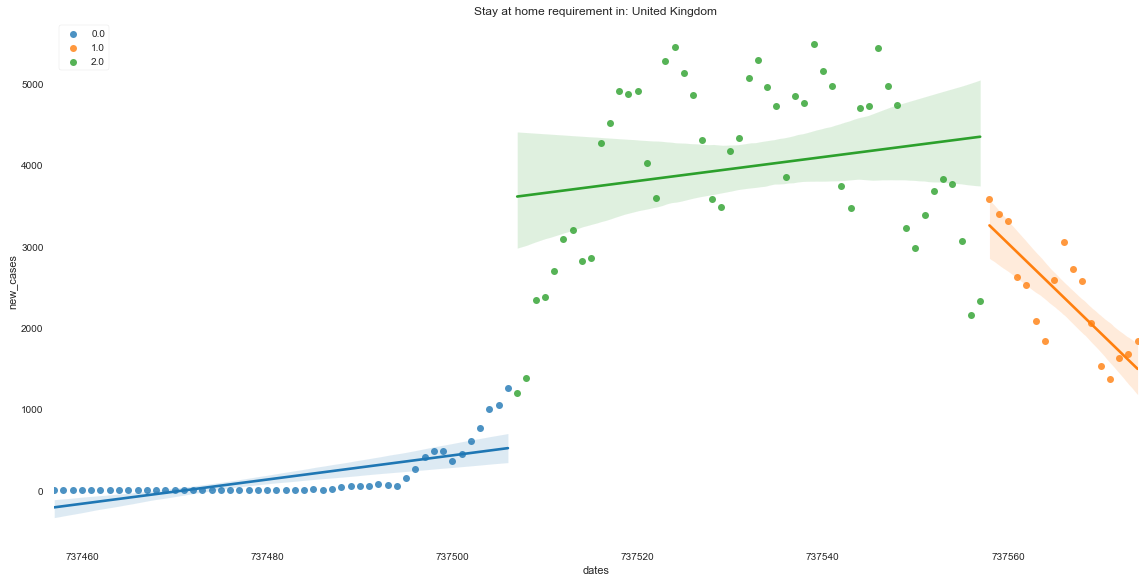

Germany


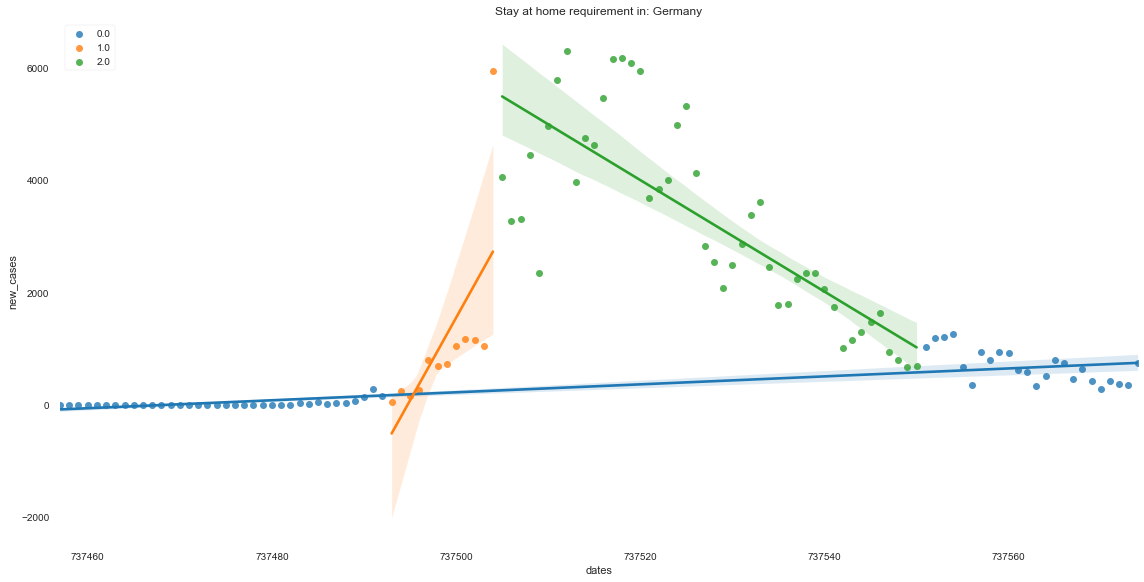

South Korea


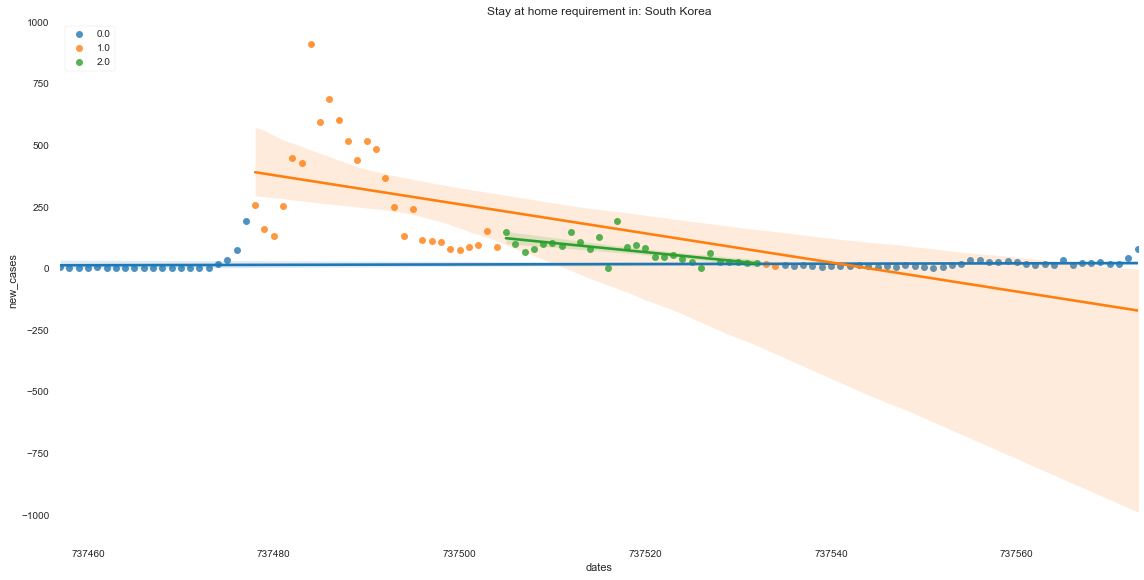

In [32]:
### Stay at home order vs cases

# Coutries selected
countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy',
              'United Kingdom', 'Germany', 'South Korea']

# Range
dstart = '2020-02-01'
dend = '2020-05-30'

for country in countries1:
    print(country)
    temp = []
    temp = merge[merge.location.isin([country])]
    temp = temp[(temp['date'] > dstart) & (temp['date'] < dend)]

    #Create num dates
    temp['dates'] = mdates.date2num(temp.date)

    # Plot
    f = sns.lmplot(data=temp, x="dates", y='new_cases', hue="C6_Stay at home requirements", height=8, aspect=2,
                  legend_out=False)
    plt.legend(loc=2)
    plt.title('Stay at home requirement in: ' + country)
    plt.savefig('output/Stay_at_home_cases_' + country + '.png', format="PNG", dpi=300, bbox_inches='tight')
    plt.show()

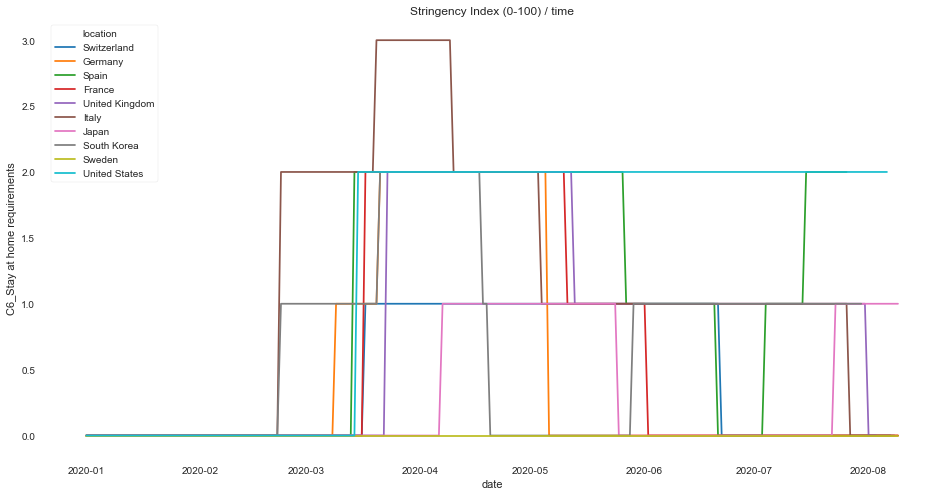

In [33]:
### Stay home Index vs time

countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy',
              'United Kingdom', 'Germany', 'South Korea', 'Japan']

f, ax = plt.subplots(figsize=(16, 8))
df2 = df[df.location.isin(countries1)]
ax = sns.lineplot(data=df2, x="date", y="C6_Stay at home requirements", hue='location')

#axes limit
#ax.set(xlim=(10, 1000000))
#ax.set(ylim=(0, 3.5))

#scale
#ax.set(xscale='log')

plt.title('Stringency Index (0-100) / time')
plt.savefig('output/Stay_at_home_Index_vs_time' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

## Stringency Index

In [34]:
### Merge Google database with merge

merge_gf = pd.merge(merge, gf, how = 'inner', on = ['location','date'], suffixes=('_left', '_right'))
merge_gf = merge_gf.rename(columns = {'iso_code_right' : 'iso_3'})

merge_gf_original = merge_gf

# Drop columns
merge_gf = merge_gf[['location','sub_region_1', 'sub_region_2', 'date', 'new_cases', 'total_cases', 'total_cases_per_million', 'new_deaths', 'total_deaths',
                           'stringency_index', 'continent', 'retail_and_recreation_percent_change_from_baseline',
                          'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline',
                          'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline',
                          'residential_percent_change_from_baseline']]

merge_gf.to_csv('data/merge_gf.csv') #Save file locally
#merge_gf.info()

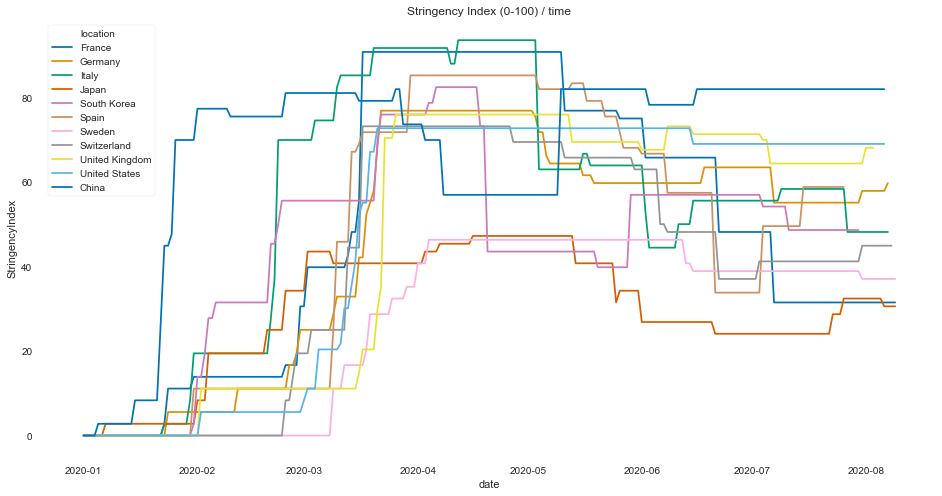

In [35]:
### Stringency Index vs time

countries1 = ['France', 'Germany', 'Italy', 'Japan', 'South Korea', 'Spain', 'Sweden', 'Switzerland',
              'United Kingdom', 'United States', 'China']

f, ax = plt.subplots(figsize=(16, 8))
df2 = df[df.location.isin(countries1)]
ax = sns.lineplot(data=df2, x="date", y="StringencyIndex", hue='location', palette='colorblind', hue_order=countries1)

#axes limit
#ax.set(xlim=(10, 1000000))
#ax.set(ylim=(0, 3.5))

#scale
#ax.set(xscale='log')

plt.title('Stringency Index (0-100) / time')
plt.savefig('output/Stringency_Index_vs_time' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'countries2' is not defined

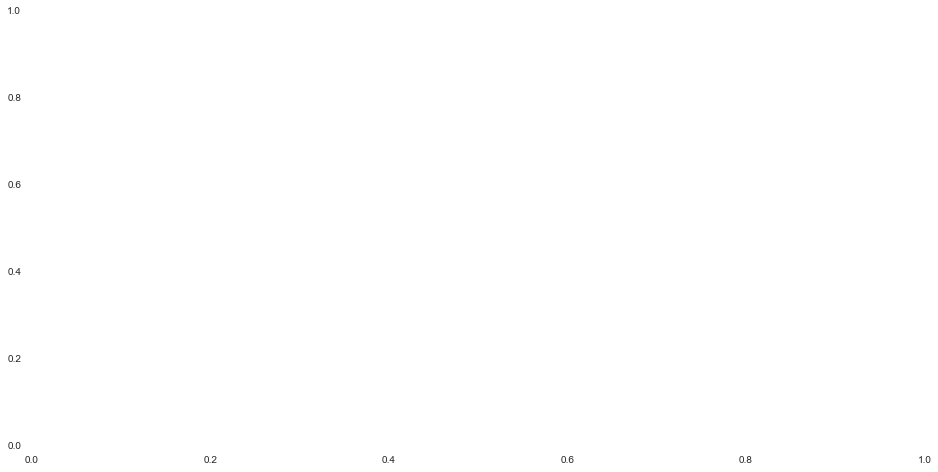

In [36]:
### Stringency Index vs time

countries2 = ['Saudi Arabia', 'China', 'Liberia', 'Cameroon', 'Venezuela', 'Russia', 'Philippines', 'Iran']

f, ax = plt.subplots(figsize=(16, 8))
df2 = df[df.location.isin(countries2)]
ax = sns.lineplot(data=df2, x="date", y="StringencyIndex", hue='location', palette='colorblind')

#axes limit
#ax.set(xlim=(10, 1000000))
#ax.set(ylim=(0, 3.5))

#scale
#ax.set(xscale='log')

plt.title('Stringency Index (0-100) / time')
plt.savefig('output/Stringency_Index_vs_time_2' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### Stringency vs total cases

countries1 = ['France', 'Germany', 'Italy', 'Japan', 'South Korea', 'Spain', 'Sweden', 'Switzerland',
              'United Kingdom', 'United States']

# Range
dstart = '2020-02-01'
dend = '2020-07-31'

temp = []
temp = merge_gf[merge_gf.location.isin(countries1)]
temp = temp[(temp['date'] > dstart ) & (temp['date'] < dend )]

# Plot 1
f, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(data=temp, x="total_cases", y="stringency_index", hue='location', palette='colorblind', hue_order=countries1)
ax.set(xscale='log')
plt.legend(loc=2)
#plt.ylabel('Google Indexes')
#ax.set(ylim=(-100, 100))
ax.set(xlim=(1, 1000000))
ax.set(ylim=(0, 110))


plt.title('Stringency Index vs total cases')
plt.savefig('output/Stringency_Index_vs_cases_countries.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### Stringency vs total cases

countries2 = ['Saudi Arabia', 'China', 'Liberia', 'Cameroon', 'Venezuela', 'Russia', 'Philippines', 'Iran']

# Range
dstart = '2020-02-01'
dend = '2020-07-31'

temp = []
temp = merge_gf[merge_gf.location.isin(countries2)]
temp = temp[(temp['date'] > dstart ) & (temp['date'] < dend )]

# Plot 1
f, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(data=temp, x="total_cases", y="stringency_index", hue='location', palette='colorblind')
ax.set(xscale='log')
plt.legend(loc=2)
#plt.ylabel('Google Indexes')
#ax.set(ylim=(-100, 100))
ax.set(xlim=(1, 1000000))
ax.set(ylim=(0, 110))

plt.title('Stringency Index vs total cases')
plt.savefig('output/Stringency_Index_vs_cases_countries2.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### Coutries selected per million

countries1 = ['France', 'Germany', 'Italy', 'Japan', 'South Korea', 'Spain', 'Sweden', 'Switzerland',
              'United Kingdom', 'United States']

# Range
dstart = '2020-02-01'
dend = '2020-07-31'

temp = []
temp = merge_gf[merge_gf.location.isin(countries1)]
temp = temp[(temp['date'] > dstart ) & (temp['date'] < dend )]

# Plot 1
f, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(data=temp, x="total_cases_per_million", y="stringency_index", hue='location', palette='colorblind')
ax.set(xscale='log')
plt.legend(loc=2)
#plt.ylabel('Google Indexes')
#ax.set(ylim=(-100, 100))
ax.set(xlim=(1, 10000))
ax.set(ylim=(0, 110))


plt.title('Stringency Index vs total cases per million')
plt.savefig('output/Stringency_Index_vs_cases_per_million_countries.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### Stay home Index vs time

countries1 = ['France', 'Germany', 'Italy', 'Japan', 'South Korea', 'Spain', 'Sweden', 'Switzerland',
              'United Kingdom', 'United States', 'China']

f, ax = plt.subplots(figsize=(16, 8))
df2 = merge[merge.location.isin(countries1)]
ax = sns.lineplot(data=df2, x="total_cases", y="C6_Stay at home requirements", hue='location', palette='colorblind')

#axes limit
#ax.set(xlim=(10, 1000000))
#ax.set(ylim=(0, 3.5))

#scale
ax.set(xscale='log')

plt.title('C6 Stay at home requirements')
plt.savefig('output/Stay_at_home_Index_vs_total_cases_countries1' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### Stay home Index vs time

countries2 = ['Saudi Arabia', 'China', 'Liberia', 'Cameroon', 'Venezuela', 'Russia', 'Philippines', 'Iran']


f, ax = plt.subplots(figsize=(16, 8))
df2 = merge[merge.location.isin(countries2)]
ax = sns.lineplot(data=df2, x="total_cases", y="C6_Stay at home requirements", hue='location', palette='colorblind')

#axes limit
#ax.set(xlim=(10, 1000000))
#ax.set(ylim=(0, 3.5))

#scale
ax.set(xscale='log')

plt.title('C6 Stay at home requirements')
plt.savefig('output/Stay_at_home_Index_vs_total_cases_countries2' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### Stay at home order vs deaths

# Coutries selected
countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy',
              'United Kingdom', 'Germany', 'South Korea']

# Range
dstart = '2020-02-01'
dend = '2020-05-30'

for country in countries1:
    print(country)
    temp = []
    temp = merge[merge.location.isin([country])]
    temp = temp[(temp['date'] > dstart) & (temp['date'] < dend)]

    #Create num dates
    temp['dates'] = mdates.date2num(temp.date)

    # Plot
    f = sns.lmplot(data=temp, x="dates", y='new_deaths', hue="C6_Stay at home requirements", height=8, aspect=2,
                  legend_out=False)
    plt.legend(loc=2)
    plt.title('Stay at home requirement in: ' + country)
    plt.savefig('output/Stay_at_home_vs_new_deaths_' + country + '.png', format="PNG", dpi=300, bbox_inches='tight')
    plt.show()

## Cases vs stringency index

In [ ]:
### Stringency vs cases

# Coutries selected
countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy',
              'United Kingdom', 'Germany', 'South Korea']

# Range
dstart = '2020-02-01'
dend = '2020-05-30'

for country in countries1:
    print(country)
    temp = []
    temp = merge[merge.location.isin([country])]
    temp = temp[(temp['date'] > dstart) & (temp['date'] < dend)]

    # Extract the data we're interested in
    x, y = temp['date'], temp['new_cases']
    color = temp['stringency_index']

    # Scatter the points
    plt.figure(figsize=(16, 8))
    plt.scatter(x, y, label=None,
                c=color, cmap='plasma',
                linewidth=0, alpha=1)
    plt.axis(aspect='equal')
    ax.set_yscale('log')
    plt.xlabel('Date')
    plt.ylabel('New cases')
    plt.colorbar(label='Stringency Index')
    #plt.clim(0, 3)

    plt.savefig('output/Stringency_colored_' + country + '.png', format="PNG", dpi=300, bbox_inches='tight')
    plt.title(country);

In [ ]:
### Stringency Index vs total cases

# Coutries selected
countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy',
              'United Kingdom', 'Germany', 'South Korea']

# Range
dstart = '2020-02-01'
dend = '2020-05-30'

for country in countries1:
    print(country)
    temp2 = []
    temp2 = merge[merge.location.isin([country])]
    temp2 = temp2[(temp2['date'] > dstart ) & (temp2['date'] < dend )]

    # Plot 1
    f, ax = plt.subplots(figsize=(16, 8))
    ax = sns.lineplot(data=temp2, x="date", y="stringency_index", label='Stringency Index')
    ax.set(ylim=(0, 100))
    plt.legend(loc=2)

    # Plot 2
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data=temp2, x="date", y="new_cases", label='New cases', color='coral')
    ax2.set(ylim=(0, None))
    #ax2.set(yscale='log')
    plt.legend(loc=1)

    #ax.set(xlim=(10, 1000000))
    plt.title('Stringency index vs new cases:  ' + country)
    plt.savefig('output/Stringency_vs_new_cases' + country + '.png', format="PNG", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
### Compare Stringency Index with cases per million

# Coutries selected
countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy', 'United Kingdom', 'Germany', 'South Korea']

for i in countries1:
    print(i)
    temp2 = []
    temp2 = merge[merge.location.isin([i])]
    
    f, ax = plt.subplots(figsize=(16, 8))
    ax = sns.lineplot(data=temp2, x="date", y="stringency_index", label='Stringency Index')
    ax.set(ylim=(0, 100))
    plt.legend(loc=2)
    
    # Total cases plot
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data=temp2, x="date", y="new_cases_per_million", color='coral', label='New cases per million')
    ax2.set(ylim=(0, 200))
    plt.legend(loc=1)
    #ax2.set(yscale='log')
    #plt.legend(bbox_to_anchor=(0.15, 0.8))
    
    
    #ax.set(yscale='log')
    plt.title(i) 
    plt.savefig('output/Stringency_new_cases_per_million_' + i + '.png', format="PNG", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
### Comparison Stringency index vs death rate

# Coutries selected
countries1 = ['United States', 'France', 'Spain', 'Switzerland']

for i in countries1:
    print(i)
    temp2 = []
    temp2 = merge[merge.location.isin([i])]
    
    f, ax = plt.subplots(figsize=(16, 8))
    ax = sns.lineplot(data=temp2, x="date", y="stringency_index", label='Stringency Index')
    ax.set(ylim=(0, 100))
    plt.legend(loc=2)
    
    #Total cases plot
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data=temp2, x="date", y="death_rate", color='coral', label='Death rate')
    ax2.set(ylim=(0, .2))
    #ax2.set(yscale='log')
    #plt.legend(bbox_to_anchor=(0.15, 0.8))
    
    #axis
    #ax.set(yscale='log')
    plt.title(i) 
    plt.savefig('output/Stringency_death_rate_' + i + '.png', format="PNG", dpi=300, bbox_inches='tight')
    plt.show()

## Stringency Index vers new and total cases

In [ ]:
### Stringency Index vs cases vs new cases

# Coutries selected
countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy',
              'United Kingdom', 'Germany', 'South Korea']

# Range
dstart = '2020-02-01'
dend = '2020-07-31'

for country in countries1:
    print(country)
    temp = []
    temp = merge_gf[merge_gf.location.isin([country])]
    temp = temp[(temp['date'] > dstart ) & (temp['date'] < dend )]

    # Plot 1
    f, ax = plt.subplots(figsize=(16, 8))
    ax1 = sns.lineplot(data=temp, x="date", y="stringency_index", label='stringency_index', color='blue')
    #ax1.set(yscale='log')
    ax.set(ylim=(0, 100))
    plt.ylabel('stringency_index')
    plt.legend(loc=2)

    # Plot 2
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data=temp, x="date", y="total_cases", label='Total cases', color='black')
    #ax2.set(ylim=(0, 100))
    ax2.set(yscale='log')
    plt.legend(loc=1)
    
    # Plot 3
    ax3 = ax.twinx()
    ax3 = sns.lineplot(data=temp, x="date", y="new_cases", label='new_cases', color='red')
    #ax3.set(ylim=(0, 100))
    ax3.set(yscale='log')
    ax3.tick_params(axis='y', labelcolor='grey')
    #ax3.yaxis.set_label_coords(5.1, 0)
    plt.legend(loc=3)


    #ax.set(xlim=(10, 1000000))
    plt.title('Stringency Index vs Google Indexes:  ' + country)
    plt.savefig('output/Response per coutry_' + country + '.png', format="PNG", dpi=300, bbox_inches='tight')
    plt.show()

## Correlation between the stringency index and the number of cases (per country)

In [ ]:
### Compare correlations between stringency index and cases

from IPython.display import display

countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy', 'United Kingdom',
              'Germany', 'South Korea']

for i in countries1:
    print(" ")
    print(i)
    temp = []
    temp = merge[merge.location.isin([i])]
    temp = temp[['stringency_index', 'new_cases', 'total_cases', 'death_rate']]

    display(temp.corr().style.background_gradient(cmap='Reds').format("{:.3f}"))

## 2-axis relationships analysis 

Averages per country have been used for the variables.

In [ ]:
### Death Rate vs Population density

g = sns.jointplot(x='pop_density', y='death_rate', data=countries_data,
              kind="reg", dropna=True, ylim=(0,0.2), xlim=(0,1000));
# g.ax_joint.set_xscale('log')

# indices to annotate
head = countries_data[countries_data.index.isin(['Japan', 'Brazil', 'United States', 'Switzerland', 'Spain', 'Germany', 'Sweden', 'Greece', 'Italy', 'France', 'United Kingdom'])]


def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["pop_density"], r["death_rate"]), 
            xytext=(2,2) , textcoords ="offset points", )

for i in head.iterrows():
    ann(i)
# for row in tail.iterrows():
#    ann(row)

g.fig.suptitle("Relationship between death rate and population density")

plt.savefig('output/Death_rate_vs_pop_density' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### Death Rate vs Tests

g = sns.jointplot(x='test', y='death_rate', data=countries_data,
              kind="reg", dropna=True, ylim=(0,0.2), xlim=(0,200));
# g.ax_joint.set_xscale('log')

# indices to annotate
head = countries_data[countries_data.index.isin(['Japan', 'Brazil', 'United States', 'Switzerland', 'Spain', 'Germany', 'Sweden', 'Greece', 'Italy', 'France', 'United Kingdom'])]


def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["test"], r["death_rate"]), 
            xytext=(2,2) , textcoords ="offset points", )

for i in head.iterrows():
    ann(i)
# for row in tail.iterrows():
#    ann(row)

g.fig.suptitle("Relationship between death rate and tests per thousand")

plt.savefig('output/Tests_vs_death_rate' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### Death Rate vs > 65 years old

g = sns.jointplot(x='y65', y='death_rate', data=countries_data,
              kind="reg", dropna=True, ylim=(0,0.2), xlim=(0,30));
# g.ax_joint.set_xscale('log')

#indices to annotate
head = countries_data[countries_data.index.isin(['Japan', 'Brazil', 'United States', 'Switzerland', 'Spain', 'Germany', 'Sweden', 'Greece', 'Italy', 'France', 'United Kingdom'])]


def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["y65"], r["death_rate"]), 
            xytext=(2,2) , textcoords ="offset points", )

for i in head.iterrows():
    ann(i)
#for row in tail.iterrows():
#    ann(row)

g.fig.suptitle("Relationship between death rate and portion of > 65 years old")

plt.savefig('output/Y65_vs_death_rate' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### Death Rate vs number of beds per thousand

g = sns.jointplot(x='beds', y='death_rate', data=countries_data,
              kind="reg", dropna=True, ylim=(0,0.2), xlim=(0,15));
# g.ax_joint.set_xscale('log')

#indices to annotate
head = countries_data[countries_data.index.isin(['Japan', 'Brazil', 'United States', 'Switzerland', 'Spain', 'Germany', 'Sweden', 'Greece', 'Italy', 'France', 'United Kingdom'])]


def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["beds"], r["death_rate"]), 
            xytext=(2,2) , textcoords ="offset points", )

for i in head.iterrows():
    ann(i)
#for row in tail.iterrows():
#    ann(row)

g.fig.suptitle("Relationship between death rate and beds per thousand")

plt.savefig('output/Death_rate_vs_number_of_beds' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### GDP vs number cases per million

g = sns.jointplot(x='gdp', y='max_cases_per_m', data=countries_data,
              kind="reg", dropna=True, xlim=(0,100000), ylim=(0,20000));
#g.ax_joint.set_xscale('log')

#indices to annotate
head = countries_data[countries_data.index.isin(['Brazil', 'United States', 'Switzerland', 'Spain', 'Germany', 'Sweden', 'Greece', 'Italy', 'France', 'United Kingdom'])]
        
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["gdp"], r["max_cases_per_m"]), 
            xytext=(2,2) , textcoords ="offset points", )

for i in head.iterrows():
    ann(i)
#for row in tail.iterrows():
#    ann(row)

g.fig.suptitle("Relationship between number of cases per million and GDP per capita")

plt.savefig('output/Total_cases_vs_GDP' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### GDP vs number deaths per million

g = sns.jointplot(x='gdp', y='max_deaths_per_m', data=countries_data,
              kind="reg", dropna=True, xlim=(0,100000));
#g.ax_joint.set_xscale('log')

#indices to annotate
head = countries_data[countries_data.index.isin(['Brazil', 'United States', 'Switzerland', 'Spain', 'Germany', 'Sweden', 'Greece', 'Italy', 'France', 'United Kingdom'])]
        
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["gdp"], r["max_deaths_per_m"]), 
            xytext=(2,2) , textcoords ="offset points", )

for i in head.iterrows():
    ann(i)
#for row in tail.iterrows():
#    ann(row)

g.fig.suptitle("Relationship between number of deaths per million and GDP per capita")

plt.savefig('output/Total_deaths_vs_GDP' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### Death rate vs number deaths

g = sns.jointplot(x='max_deaths', y='death_rate', data=countries_data,
              kind="reg", dropna=True, ylim=(0,0.2));
g.ax_joint.set_xscale('log')

#indices to annotate
head = countries_data[countries_data.index.isin(['Japan', 'Brazil', 'United States', 'Switzerland', 'Spain', 'Germany', 'Sweden', 'Greece', 'Italy', 'France', 'United Kingdom'])]
        
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["max_deaths"], r["death_rate"]), 
            xytext=(2,2) , textcoords ="offset points", )

for i in head.iterrows():
    ann(i)
#for row in tail.iterrows():
#    ann(row)


g.fig.suptitle("Relationship between death rate and number of deaths")
plt.savefig('output/Death_rate_vs_total_deaths' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### Death rate vs number deaths per million

g = sns.jointplot(x='max_deaths_per_m', y='death_rate', data=countries_data,
              kind="reg", dropna=True, ylim=(0,0.2));
g.ax_joint.set_xscale('log')

#indices to annotate
head = countries_data[countries_data.index.isin(['Japan', 'Netherlands', 'Belgium', 'Brazil', 'United States', 'Switzerland', 'Spain', 'Germany', 'Sweden', 'Greece', 'Italy', 'France', 'United Kingdom'])]
        
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["max_deaths_per_m"], r["death_rate"]), 
            xytext=(2,2) , textcoords ="offset points", )

for i in head.iterrows():
    ann(i)
#for row in tail.iterrows():
#    ann(row)


g.fig.suptitle("Relationship between death rate and number of deaths per million")

plt.savefig('output/Death_rate_vs_deaths_per_m' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

# Democratic Index

In [ ]:
### Demographic index vs Stringency

# Plot
g = sns.jointplot(x='democratic_index', y='mean_stringency', data=countries_data,
              kind="reg", dropna=True, ylim=(0,100), xlim=(0,10));
# g.ax_joint.set_xscale('log')

#indices to annotate
head = countries_data[countries_data.index.isin(['Japan', 'Brazil', 'United States', 'Switzerland', 'Germany',
                                     'Sweden', 'Greece', 'Italy', 'France',
                                    'Russia', 'Saudi Arabia', 'China', 'Venezuela', 'Cameroon', 'Liberia'])]


def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["democratic_index"], r["mean_stringency"]), 
            xytext=(2,2) , textcoords ="offset points", )

for i in head.iterrows():
    ann(i)
#for row in tail.iterrows():
#    ann(row)

g.fig.suptitle("Average stringency index vs democratic index")

plt.savefig('output/Democracy_index_vs_stringecy' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### GDP vs Stringency

# Plot

g = sns.jointplot(x='gdp', y='mean_stringency', data=countries_data,
              kind="reg", dropna=True, ylim=(0,100));
# g.ax_joint.set_xscale('log')

#indices to annotate
head = countries_data[countries_data.index.isin(['Japan', 'Brazil', 'United States', 'Switzerland', 'Germany',
                                     'Sweden', 'Greece', 'Italy', 'France',
                                    'Russia', 'Saudi Arabia', 'China', 'Venezuela', 'Cameroon', 'Liberia'])]


def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["gdp"], r["mean_stringency"]), 
            xytext=(2,2) , textcoords ="offset points", )

for i in head.iterrows():
    ann(i)
#for row in tail.iterrows():
#    ann(row)

g.fig.suptitle("Average stringency index vs democratic index")

plt.savefig('output/GDP_vs_stringecy' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### Max cases vs Stringency

g = sns.jointplot(x='max_cases', y='mean_stringency', data=countries_data,
              kind="reg", dropna=True, ylim=(0,100));
g.ax_joint.set_xscale('log')

#indices to annotate
head = countries_data[countries_data.index.isin(['Japan', 'Brazil', 'United States', 'Switzerland', 'Germany',
                                     'Sweden', 'Greece', 'Italy', 'France',
                                    'Russia', 'Saudi Arabia', 'China', 'Venezuela', 'Cameroon', 'Liberia'])]


def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["max_cases"], r["mean_stringency"]), 
            xytext=(2,2) , textcoords ="offset points", )

for i in head.iterrows():
    ann(i)
#for row in tail.iterrows():
#    ann(row)

g.fig.suptitle("Average stringency index vs total cases")

plt.savefig('output/max_cases_vs_stringency' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
### Democratic index vs max cases

# Plot
g = sns.jointplot(x='democratic_index', y='max_cases', data=countries_data,
              kind="reg", dropna=True);
g.ax_joint.set_yscale('log')

#indices to annotate
head = countries_data[countries_data.index.isin(['Japan', 'Brazil', 'United States', 'Switzerland', 'Germany',
                                     'Sweden', 'Greece', 'Italy', 'France',
                                    'Russia', 'Saudi Arabia', 'China', 'Venezuela', 'Cameroon', 'Liberia'])]
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["democratic_index"], r["max_cases"]), 
            xytext=(2,2) , textcoords ="offset points", )

for i in head.iterrows():
    ann(i)
#for row in tail.iterrows():
#    ann(row)

g.fig.suptitle("Average stringency index vs democratic index")

plt.savefig('output/Democracy_index_vs_max_cases' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

## Max response vs max cases

In [ ]:
### Max gov response vs max cases

temp = merge

gov = temp.groupby(['location'])['GovernmentResponseIndex'].max()
cases_max = temp.groupby(['location'])['total_cases'].max()

frame = { 'max_cases': cases_max, 'max_gov_resp': gov } 
max_cases_gov_response = pd.DataFrame(frame) 


g = sns.jointplot(x='max_cases', y='max_gov_resp', data=max_cases_gov_response,
              kind="reg", xlim=(10,1000000), ylim=(0,110), dropna=True);
g.ax_joint.set_xscale('log')
g.fig.suptitle('max_gov_resp / max_cases')
plt.savefig('output/max_gov_resp vs max_cases' + '.png', format="PNG", dpi=300, bbox_inches='tight')

# Analysis of the Google Indexes 

In [ ]:
### Google indexes

f, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(data=gf, x="date", y="retail_and_recreation_percent_change_from_baseline", label='retail_and_recreation_percent_change_from_baseline')
ax = sns.lineplot(data=gf, x="date", y="grocery_and_pharmacy_percent_change_from_baseline", label='grocery_and_pharmacy_percent_change_from_baseline')
ax = sns.lineplot(data=gf, x="date", y="parks_percent_change_from_baseline", label='parks_percent_change_from_baseline')
ax = sns.lineplot(data=gf, x="date", y="transit_stations_percent_change_from_baseline", label='transit_stations_percent_change_from_baseline')
ax = sns.lineplot(data=gf, x="date", y="workplaces_percent_change_from_baseline", label='workplaces_percent_change_from_baseline')
ax = sns.lineplot(data=gf, x="date", y="residential_percent_change_from_baseline", label='residential_percent_change_from_baseline', color='black')

#ax.set(xlim=(10, 1000000))
#ax.set(xscale='log')
plt.title('Average Mobility change (World)')
plt.savefig('output/Google_indexes_World' + '.png', format="PNG", dpi=300, bbox_inches='tight')
plt.show()

## Comparison with Stringency Indexes

In [ ]:
### Google Indexes vs Stringency Index in Continents

continents = ['North America', 'South America', 'Asia', 'Oceania', 'Africa', 'Europe']

# Range
dstart = '2020-02-01'
dend = '2020-07-31'

for continent in continents:
    print(continent)
    temp = []
    temp = merge_gf[merge_gf.continent.isin([continent])]
    temp = temp[(temp['date'] > dstart ) & (temp['date'] < dend )]

    # Plot 1
    f, ax = plt.subplots(figsize=(16, 8))
    ax = sns.lineplot(data=temp, x="date", y="retail_and_recreation_percent_change_from_baseline", label='Retail and recreation percent change from baseline')
    ax = sns.lineplot(data=temp, x="date", y="residential_percent_change_from_baseline", label='Residential percent change from baseline')
    ax = sns.lineplot(data=temp, x="date", y="parks_percent_change_from_baseline", label='Parks percent change from baseline') 
    plt.ylabel('Google Indexes')
    ax.set(ylim=(-100, 100))
    plt.legend(loc=2)

    # Plot 2
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data=temp, x="date", y="stringency_index", label='Stringency Index', color='black')
    ax2.set(ylim=(0, 100))
    #ax2.set(yscale='log')
    plt.legend(loc=1)

    #ax.set(xlim=(10, 1000000))
    plt.title('Stringency Index vs Google Indexes:  ' + continent)
    plt.savefig('output/Stringency_index_vs_mobility_indexes_' + continent + '.png', format="PNG", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
### Google Indexes vs Stringency Index

# Coutries selected
countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy',
              'United Kingdom', 'Germany', 'South Korea']

# Range
dstart = '2020-02-01'
dend = '2020-07-31'

for country in countries1:
    print(country)
    temp = []
    temp = merge_gf[merge_gf.location.isin([country])]
    temp = temp[(temp['date'] > dstart ) & (temp['date'] < dend )]

    # Plot 1
    f, ax = plt.subplots(figsize=(16, 8))
    ax = sns.lineplot(data=temp, x="date", y="retail_and_recreation_percent_change_from_baseline", label='Retail and recreation percent change from baseline')
    ax = sns.lineplot(data=temp, x="date", y="residential_percent_change_from_baseline", label='Residential percent change from baseline')
    ax = sns.lineplot(data=temp, x="date", y="parks_percent_change_from_baseline", label='Parks percent change from baseline') 
    plt.ylabel('Google Indexes')
    ax.set(ylim=(-100, 100))
    plt.legend(loc=2)

    # Plot 2
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data=temp, x="date", y="stringency_index", label='Stringency Index', color='black')
    ax2.set(ylim=(0, 100))
    #ax2.set(yscale='log')
    plt.legend(loc=1)

    #ax.set(xlim=(10, 1000000))
    plt.title('Stringency Index vs Google Indexes:  ' + country)
    plt.savefig('output/Stringency_index_vs_mobility_indexes_' + country + '.png', format="PNG", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
### Google Indexes vs Stringency Index vs new cases

# Coutries selected
countries1 = ['United States', 'France', 'Spain', 'Switzerland', 'Sweden', 'Italy',
              'United Kingdom', 'Germany', 'South Korea']

# Range
dstart = '2020-02-01'
dend = '2020-07-31'

for country in countries1:
    print(country)
    temp = []
    temp = merge_gf[merge_gf.location.isin([country])]
    temp = temp[(temp['date'] > dstart ) & (temp['date'] < dend )]

    # Plot 1
    f, ax = plt.subplots(figsize=(16, 8))
    ax = sns.lineplot(data=temp, x="date", y="retail_and_recreation_percent_change_from_baseline", label='Retail and recreation percent change from baseline')
    ax = sns.lineplot(data=temp, x="date", y="residential_percent_change_from_baseline", label='Residential percent change from baseline')
    ax = sns.lineplot(data=temp, x="date", y="parks_percent_change_from_baseline", label='Parks percent change from baseline') 
    plt.ylabel('Google Indexes')
    ax.set(ylim=(-100, 100))
    plt.legend(loc=2)

    # Plot 2
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data=temp, x="date", y="stringency_index", label='Stringency Index', color='black')
    ax2.set(ylim=(0, 100))
    #ax2.set(yscale='log')
    plt.legend(loc=1)
    
    # Plot 3
    ax3 = ax.twinx()
    ax3 = sns.lineplot(data=temp, x="date", y="new_cases", label='new_cases', color='red')
    #ax3.set(ylim=(0, 100))
    ax3.set(yscale='log')
    ax3.tick_params(axis='y', labelcolor='grey')
    #ax3.yaxis.set_label_coords(5.1, 0)
    plt.legend(loc=3)

    #ax.set(xlim=(10, 1000000))
    plt.title('Stringency Index vs Google Indexes:  ' + country)
    plt.savefig('output/Stringency_mobility_deaths_' + country + '.png', format="PNG", dpi=300, bbox_inches='tight')
    plt.show()




## Correlations with Google Indexes

In [ ]:
### Correlations
merge_gf.corr().style.background_gradient(cmap='Reds').format("{:.3f}")

In [ ]:
temp1 = merge.groupby(['date'])['stringency_index'].mean()
temp2 = merge.groupby(['date'])['GovernmentResponseIndex'].mean()
temp3 = merge.groupby(['date'])['ContainmentHealthIndex'].mean()
temp4 = merge.groupby(['date'])['EconomicSupportIndex'].mean()
temp5 = merge.groupby(['date'])['total_cases'].sum()
temp6 = merge.groupby(['date'])['new_cases'].sum()
frame2 = { 'stringency_index': temp1, 'GovernmentResponseIndex': temp2, 'ContainmentHealthIndex': temp3, 'EconomicSupportIndex': temp4, 'total_cases': temp5, 'new_cases': temp6} 

gov_index_means = pd.DataFrame(frame2) 
  
#print(gov_index_means)

In [ ]:
### merge google mobility indexes and Oxford stringency indexes

gov_index_means_gf = pd.merge(gov_index_means, gf, how = 'inner', on = ['date'])

In [ ]:
### Correlations

gov_index_means_gf.corr().style.background_gradient(cmap='Reds').format("{:.3f}")

In [ ]:
### Stringency index vs residential change

g = sns.jointplot(x='stringency_index', y='residential_percent_change_from_baseline', data=gov_index_means_gf,
              kind="reg", dropna=True);

#the more stringency, the more people stay home.

In [ ]:
### Stringency index vs park change

g = sns.jointplot(x='stringency_index', y='parks_percent_change_from_baseline', data=gov_index_means_gf,
              kind="reg", xlim=(0,100), ylim=(-100,100), dropna=True);

# The relationship is dependant from time, it doesn't work

In [ ]:
### Stringency index vs new cases

g = sns.jointplot(x='new_cases', y='stringency_index', data=gov_index_means_gf,
              kind="reg", dropna=True);

In [ ]:
### New cases vs residential change

g = sns.jointplot(x='new_cases', y='residential_percent_change_from_baseline', data=gov_index_means_gf,
              kind="reg", ylim=(-50, 50), dropna=True);

## Thank you for reaching this point :)

Leo